## Обработка графиков ЭКГ и преобразование в таблицу

In [1]:
import pywt
import scipy
import os
from pylab import *
from numpy import*
import pandas as pd

import matplotlib.pyplot as plt
from peakdetect import peakdetect
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split

In [2]:
def get_ecg(key, directory): # получение закодированного графика экг из файла
    way = directory + key + '.npy'
    ecgsig = np.load(way).transpose().reshape((60000,))
    x = np.linspace(0,  1,  num = 2048)
    data = np.sin(250 * np.pi * x**2)
    coefs = pywt.downcoef('a', data, 'db20', mode='symmetric', level=1)
    st='sym5'
    coeffs = pywt.wavedec(ecgsig, st, level=5)
    row = coeffs[0]
    return row

In [3]:
def into_one_table(keys, directory): # преобразование графиков в таблицу
    row = get_ecg(keys[0], directory)
    row = np.insert(row, 0, int(keys[0].strip('_hr')))
    table = [row]
    for i in range(target.index.start + 1, target.index.stop):
        row = get_ecg(keys[i], directory)
        row = np.insert(row, 0, int(keys[i].strip('_hr')))
        table = np.vstack([table, row])
    table = pd.DataFrame(table)
    return table

In [22]:
%%time
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('train')[:-3])))
ECG_data = into_one_table(target, 'train/') # таблица с графиками

CPU times: total: 9.83 s
Wall time: 14.4 s


In [23]:
ECG_data[0] = ECG_data[0].astype('int')
ECG_data = ECG_data.rename(columns={0: 'record_name'})

In [24]:
ECG_data = ECG_data.sort_values(by=['record_name'], ascending=True)

In [25]:
ECG_data

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,9,-0.170442,-0.066933,-0.140079,-0.478502,-1.245167,-0.979738,-0.738943,-0.476043,-0.349288,...,0.558936,0.551860,0.551007,0.561618,0.556675,0.645774,0.744957,0.649421,0.667106,0.731759
1,34,0.399648,0.579593,0.460080,-0.077166,-1.270282,-1.040847,-1.689153,-2.481032,-2.205554,...,1.113606,1.088111,1.099680,1.132341,1.130250,1.788834,2.455783,1.818630,1.938019,2.363243
2,43,0.411589,0.365335,0.399006,0.554728,0.911140,0.774487,0.576258,0.404740,0.229235,...,0.341701,0.340029,0.342162,0.341734,0.340499,0.346990,0.366654,0.343959,0.348800,0.365320
3,52,-0.162251,-0.159025,-0.159327,-0.163111,-0.158814,-0.159398,-0.162262,-0.174764,-0.179583,...,-0.267047,-0.258175,-0.261318,-0.274144,-0.273755,-0.519687,-0.765086,-0.532849,-0.575938,-0.730437
4,57,-0.268330,-0.279812,-0.270770,-0.232069,-0.136626,-0.155710,-0.117283,-0.096148,-0.074360,...,-0.304742,-0.297821,-0.302716,-0.310384,-0.311176,-0.513279,-0.714933,-0.521431,-0.558040,-0.686983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,-0.094946,-0.097736,-0.095932,-0.087848,-0.070772,-0.076037,-0.082161,-0.089443,-0.092388,...,0.005842,0.004748,0.005003,0.006885,0.006829,0.041791,0.079657,0.044349,0.050701,0.074361
2097,21795,-0.194416,-0.182553,-0.191956,-0.238293,-0.352612,-0.314071,-0.319038,-0.313175,-0.285890,...,0.120157,0.117738,0.121368,0.121892,0.122540,0.189928,0.260724,0.190226,0.204078,0.251573
2098,21825,-0.004072,-0.000198,-0.003268,-0.017719,-0.054790,-0.048271,-0.088630,-0.084493,-0.070101,...,-0.128999,-0.124998,-0.127924,-0.131497,-0.131004,-0.222249,-0.318699,-0.224482,-0.242503,-0.305902
2099,21831,-0.128454,-0.127641,-0.128944,-0.136319,-0.158699,-0.147968,-0.147763,-0.142817,-0.138197,...,-0.159457,-0.155589,-0.158779,-0.161389,-0.160510,-0.233738,-0.313892,-0.233884,-0.249503,-0.303710


## Объединение таблиц, разбиение на тренировочный и валидационный датасет

In [26]:
df = pd.read_csv('train/train_meta.csv')
df.record_name = list(map(lambda x: int(x.strip('_hr')), df.record_name))
df

,patient_id,age,sex,height,weight,record_name
0,18792.0,55.0,0,NaN,70.0,9
1,13619.0,56.0,0,NaN,NaN,34
2,11315.0,25.0,1,NaN,63.0,43
3,18153.0,35.0,0,NaN,82.0,52
4,16063.0,26.0,0,NaN,93.0,57
...,...,...,...,...,...,...
2096,12488.0,66.0,1,NaN,NaN,21784
2097,10162.0,68.0,0,NaN,NaN,21795
2098,11197.0,59.0,0,NaN,NaN,21825
2099,11905.0,55.0,1,NaN,NaN,21831


In [27]:
ECG_data = ECG_data.merge(df, on='record_name', how='left')

In [28]:
gts = pd.read_csv('train/train_gts_final.csv')
gts.record_name = list(map(lambda x: int(x.strip('_hr')), gts.record_name))
gts

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма,record_name
0,0,0,0,0,0,0,1,669
1,0,0,0,0,0,0,1,209
2,0,0,0,0,0,0,1,777
3,0,0,0,0,0,0,1,1394
4,0,0,0,0,0,0,1,1618
...,...,...,...,...,...,...,...,...
2096,0,0,0,0,0,0,1,20864
2097,0,0,0,0,0,0,1,20967
2098,0,0,0,0,0,0,1,21744
2099,0,0,0,0,0,0,1,3465


In [29]:
ECG_data = ECG_data.merge(gts, on='record_name', how='left')

In [36]:
ECG_data

,record_name,1,2,3,4,5,6,7,8,9,...,1879,1880,1881,1882,1883,patient_id,age,sex,height,weight
0,9,-0.170442,-0.066933,-0.140079,-0.478502,-1.245167,-0.979738,-0.738943,-0.476043,-0.349288,...,0.645774,0.744957,0.649421,0.667106,0.731759,18792.0,55.0,0,NaN,70.0
1,34,0.399648,0.579593,0.460080,-0.077166,-1.270282,-1.040847,-1.689153,-2.481032,-2.205554,...,1.788834,2.455783,1.818630,1.938019,2.363243,13619.0,56.0,0,NaN,NaN
2,43,0.411589,0.365335,0.399006,0.554728,0.911140,0.774487,0.576258,0.404740,0.229235,...,0.346990,0.366654,0.343959,0.348800,0.365320,11315.0,25.0,1,NaN,63.0
3,52,-0.162251,-0.159025,-0.159327,-0.163111,-0.158814,-0.159398,-0.162262,-0.174764,-0.179583,...,-0.519687,-0.765086,-0.532849,-0.575938,-0.730437,18153.0,35.0,0,NaN,82.0
4,57,-0.268330,-0.279812,-0.270770,-0.232069,-0.136626,-0.155710,-0.117283,-0.096148,-0.074360,...,-0.513279,-0.714933,-0.521431,-0.558040,-0.686983,16063.0,26.0,0,NaN,93.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,21784,-0.094946,-0.097736,-0.095932,-0.087848,-0.070772,-0.076037,-0.082161,-0.089443,-0.092388,...,0.041791,0.079657,0.044349,0.050701,0.074361,12488.0,66.0,1,NaN,NaN
2097,21795,-0.194416,-0.182553,-0.191956,-0.238293,-0.352612,-0.314071,-0.319038,-0.313175,-0.285890,...,0.189928,0.260724,0.190226,0.204078,0.251573,10162.0,68.0,0,NaN,NaN
2098,21825,-0.004072,-0.000198,-0.003268,-0.017719,-0.054790,-0.048271,-0.088630,-0.084493,-0.070101,...,-0.222249,-0.318699,-0.224482,-0.242503,-0.305902,11197.0,59.0,0,NaN,NaN
2099,21831,-0.128454,-0.127641,-0.128944,-0.136319,-0.158699,-0.147968,-0.147763,-0.142817,-0.138197,...,-0.233738,-0.313892,-0.233884,-0.249503,-0.303710,11905.0,55.0,1,NaN,NaN


In [33]:
gts = ECG_data[['перегородочный', 'передний', 'боковой', 'передне-боковой', 'передне-перегородочный', 'нижний', 'норма']]
gts

,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
2096,0,0,0,0,0,0,1
2097,0,0,0,0,0,0,1
2098,0,0,0,0,0,0,1
2099,0,0,0,0,0,0,1


In [35]:
ECG_data = ECG_data.drop(['перегородочный', 'передний', 'боковой', 'передне-боковой',
                          'передне-перегородочный', 'нижний', 'норма'], axis=1)

In [37]:
ECG_data_train, ECG_data_val, myocard_train, myocard_val = train_test_split(ECG_data, gts, random_state=0)

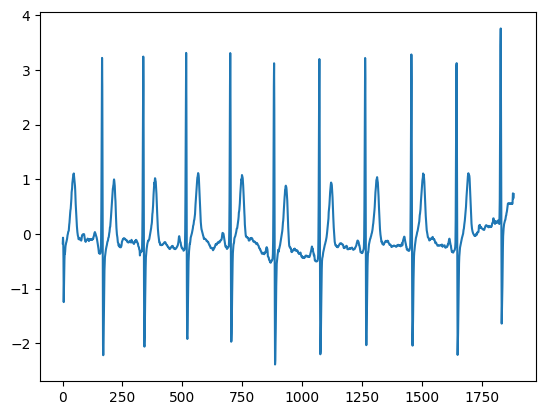

In [38]:
plt.plot(ECG_data.iloc[0, 1:-5]) # график экг после обработки сигнала

In [39]:
df_train = ECG_data_train.iloc[:, -5:]
df_val = ECG_data_val.iloc[:, -5:]

In [40]:
df_train

,patient_id,age,sex,height,weight
1592,4964.0,22.0,1,163.0,90.0
918,16196.0,84.0,0,NaN,NaN
122,767.0,61.0,0,183.0,83.0
684,12056.0,74.0,1,NaN,NaN
214,2452.0,60.0,1,152.0,NaN
...,...,...,...,...,...
1033,18617.0,49.0,0,NaN,NaN
1731,4102.0,64.0,1,168.0,66.0
763,10524.0,34.0,0,NaN,72.0
835,10717.0,55.0,0,NaN,NaN


In [41]:
ECG_data_train = ECG_data_train.iloc[:, :-5]
ECG_data_val = ECG_data_val.iloc[:, :-5]

In [42]:
ECG_data_train

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
1592,16603,0.109449,0.185223,0.125672,-0.151371,-0.829218,-0.622236,-0.656209,-0.655158,-0.620203,...,-0.276397,-0.271167,-0.271356,-0.278988,-0.276562,-0.365569,-0.453599,-0.369220,-0.385059,-0.441318
918,9557,-1.490900,-1.394463,-1.459593,-1.758585,-2.413724,-2.193418,-1.980952,-1.772527,-1.498688,...,1.808763,1.794004,1.791578,1.824338,1.824525,2.338546,2.856921,2.381495,2.466389,2.781295
122,1511,0.410295,0.418111,0.411441,0.385160,0.316728,0.322976,0.268045,0.196556,0.132210,...,0.429139,0.419976,0.423895,0.435734,0.434976,0.667413,0.897665,0.677479,0.718923,0.865508
684,7125,-0.121402,-0.121375,-0.120977,-0.119733,-0.114203,-0.115726,-0.117201,-0.126269,-0.128501,...,0.680528,0.667779,0.672897,0.689272,0.687265,0.994409,1.308699,1.007843,1.064270,1.265372
214,2316,0.028528,-0.025202,0.009788,0.172212,0.546162,0.536875,1.251363,2.411523,3.051960,...,-0.384466,-0.378909,-0.380860,-0.388554,-0.387973,-0.530641,-0.673326,-0.537565,-0.562936,-0.653343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,10677,1.348874,1.394465,1.405025,1.479370,1.920034,1.547778,0.474275,-0.755991,-1.562751,...,-0.187951,-0.184040,-0.186707,-0.190465,-0.189940,-0.280883,-0.378106,-0.283582,-0.301543,-0.365178
1731,18020,-0.285911,-0.265134,-0.282379,-0.365458,-0.574443,-0.503349,-0.498727,-0.482626,-0.459739,...,-0.247702,-0.239041,-0.247471,-0.255108,-0.257066,-0.526102,-0.801259,-0.535676,-0.586126,-0.763746
763,7978,-0.316812,-0.305549,-0.314139,-0.357382,-0.462342,-0.426322,-0.437142,-0.429418,-0.412790,...,-0.151037,-0.149981,-0.150161,-0.152364,-0.152745,-0.197529,-0.242362,-0.200993,-0.208471,-0.235857
835,8797,-0.897106,-0.901242,-0.897541,-0.887869,-0.862189,-0.857458,-0.841005,-0.826645,-0.800221,...,0.142141,0.140497,0.141669,0.143489,0.143677,0.191975,0.240699,0.193946,0.202788,0.233976


## N-граммы

In [43]:
import neurokit2
import sleepecg
import wfdb.processing
from nltk.util import ngrams

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from catboost import CatBoostClassifier

In [44]:
def find_peaks(ecgsignal, peak): # нахождение пиков
    return wfdb.processing.correct_peaks(ecgsignal, rpeaks,
            search_radius=36, smooth_window_size=50, peak_dir=peak)

In [45]:
def get_cycle(ecgsignal, rpeaks): # разбиение ЭКГ на циклы
    ecgsignal_split = []
    cycle = []
    rpeaks = rpeaks[::-1]
    f = True #флаг конца массива с пиками
    f1 = True #флаг вхождения первого пика
    for i in range(len(ecgsignal)):
        if f and i == rpeaks[-1]:
            if f1:
                f1 = False
                cycle = []
            else:
                ecgsignal_split.append(cycle)
                cycle = []
            rpeaks = rpeaks[:-1]
            if f and len(rpeaks) == 0:
                f = False
        cycle.append(ecgsignal[i])
    return ecgsignal_split

In [46]:
def sign(x): # возвращает знак числа
   return 1 if x > 0 else -1

In [47]:
def RTL(ecgsignal_split): # получение списка приращения амплитуд R, интервалов T, углов L
    sp = [[(i[0] - min(i[:10])), len(i), ((i[0] - min(i[:10]))/len(i))] for i in ecgsignal_split]
    s = []
    for i in range(len(sp) - 1):
        R = sp[i + 1][0] - sp[i][0]
        T = sp[i + 1][1] - sp[i][1]
        L = sp[i + 1][2] - sp[i][2]
        s.append([R, T, L])
    return s

In [48]:
def letters(data): # кодирование цикла по В.М. Успенскому
  if data[0] == 1:
    if data[1] == -1:
      return 'C'
    else:
      if data[2] == -1:
        return 'E'
      return 'A'
  else:
    if data[1] == 1:
      return 'D'
    else:
      if data[2] == 1:
        return 'B'
      return 'F'

In [49]:
def encoding(ecgsignal_split): # кодирование циклов в строку по В.М. Успенскому
    s = [[sign(i) for i in k] for k in RTL(ecgsignal_split)]
    stroka = ''
    for i in s:
        stroka += letters(i)
    return stroka

In [50]:
def counter_and_sort(arr): # считает и сортирует н-граммы
  quantity = {}
  for i in arr:
    if i in quantity:
      quantity[i] += 1
    else:
      quantity[i] = 1
  quantity = pd.Series(list(quantity.values()), index=list(quantity.keys())).sort_values(ascending=False)
  return quantity

In [94]:
def func(ng):  # возвращает список количества н-грамм, относящихся к каждой категории
    # н-граммы, встречающиеся только в этой категории
    ng_healthy = sum(list(map(lambda x: 1 if x in only_healthy else 0, ng))) 
    ng_sick = sum(list(map(lambda x: 1 if x in only_sick else 0, ng)))
    
    ng_septal_0 = sum(list(map(lambda x: 1 if x in only_septal_0 else 0, ng)))
    ng_septal_1 = sum(list(map(lambda x: 1 if x in only_septal_1 else 0, ng)))
    
    ng_front_0 = sum(list(map(lambda x: 1 if x in only_front_0 else 0, ng)))
    ng_front_1 = sum(list(map(lambda x: 1 if x in only_front_1 else 0, ng)))
    
    ng_side_0 = sum(list(map(lambda x: 1 if x in only_side_0 else 0, ng)))
    ng_side_1 = sum(list(map(lambda x: 1 if x in only_side_1 else 0, ng)))
    
    ng_front_side_0 = sum(list(map(lambda x: 1 if x in only_front_side_0 else 0, ng)))
    ng_front_side_1 = sum(list(map(lambda x: 1 if x in only_front_side_1 else 0, ng)))
    
    ng_front_septal_0 = sum(list(map(lambda x: 1 if x in only_front_septal_0 else 0, ng)))
    ng_front_septal_1 = sum(list(map(lambda x: 1 if x in only_front_septal_1 else 0, ng)))
    
    ng_lower_0 = sum(list(map(lambda x: 1 if x in only_lower_0 else 0, ng)))
    ng_lower_1 = sum(list(map(lambda x: 1 if x in only_lower_1 else 0, ng)))
    
    # н-граммы, которые чаще всего встречаются в этой и не встречаются в противоположной категории
    ng_popular_healthy = sum(list(map(lambda x: 1 if x in popular_healthy_only else 0, ng)))
    ng_popular_sick = sum(list(map(lambda x: 1 if x in popular_sick_only else 0, ng)))
    
    ng_popular_septal_0 = sum(list(map(lambda x: 1 if x in popular_septal_0_only else 0, ng)))
    ng_popular_septal_1 = sum(list(map(lambda x: 1 if x in popular_septal_1_only else 0, ng)))
    
    ng_popular_front_0 = sum(list(map(lambda x: 1 if x in popular_front_0_only else 0, ng)))
    ng_popular_front_1 = sum(list(map(lambda x: 1 if x in popular_front_1_only else 0, ng)))
    
    ng_popular_side_0 = sum(list(map(lambda x: 1 if x in popular_side_0_only else 0, ng)))
    ng_popular_side_1 = sum(list(map(lambda x: 1 if x in popular_side_1_only else 0, ng)))
    
    ng_popular_front_side_0 = sum(list(map(lambda x: 1 if x in popular_front_side_0_only else 0, ng)))
    ng_popular_front_side_1 = sum(list(map(lambda x: 1 if x in popular_front_side_1_only else 0, ng)))
    
    ng_popular_front_septal_0 = sum(list(map(lambda x: 1 if x in popular_front_septal_0_only else 0, ng)))
    ng_popular_front_septal_1 = sum(list(map(lambda x: 1 if x in popular_front_septal_1_only else 0, ng)))
    
    ng_popular_lower_0 = sum(list(map(lambda x: 1 if x in popular_lower_0_only else 0, ng)))
    ng_popular_lower_1 = sum(list(map(lambda x: 1 if x in popular_lower_1_only else 0, ng)))
    
    return array([[ng_healthy, ng_popular_healthy, ng_sick, ng_popular_sick],
                  [ng_septal_0, ng_popular_septal_0, ng_septal_1, ng_popular_septal_1],
                  [ng_front_0, ng_popular_front_0, ng_front_1, ng_popular_front_1],
                  [ng_side_0, ng_popular_side_0, ng_side_1, ng_popular_side_1],
                  [ng_front_side_0, ng_popular_front_side_0, ng_front_side_1, ng_popular_front_side_1],
                  [ng_front_septal_0, ng_popular_front_septal_0, ng_front_septal_1, ng_popular_front_septal_1],
                  [ng_lower_0, ng_popular_lower_0, ng_lower_1, ng_popular_lower_1]])

In [72]:
def sp_n_gramms(ngramma):  # получение н-грамм
    sp = []
    for i in ngramma:
        n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(i), 6))))
        for k in n:
            sp.append(k)
    return sp

In [52]:
ECG_data_array_train = np.array(ECG_data_train)

In [53]:
R_Peaks_train = []

In [54]:
ecg_ids_train = []
encoding_ecgs_train = []

In [55]:
for ecgsignal in ECG_data_array_train: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_train.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_train.append(ecg_id)
    encoding_ecgs_train.append(encoding_ecg)

In [62]:
encoding_ecg_train = pd.DataFrame(columns=['encoding_ecg', 'ecg_id', 'перегородочный', 'передний', 'боковой',
                                           'передне-боковой','передне-перегородочный', 'нижний', 'норма'])
encoding_ecg_train.encoding_ecg = encoding_ecgs_train
encoding_ecg_train.ecg_id = ecg_ids_train
encoding_ecg_train = encoding_ecg_train.sort_values(by='ecg_id')
encoding_ecg_train[['перегородочный', 'передний', 'боковой',
                    'передне-боковой','передне-перегородочный', 'нижний', 'норма']] = array(myocard_train)
encoding_ecg_train

,encoding_ecg,ecg_id,перегородочный,передний,боковой,передне-боковой,передне-перегородочный,нижний,норма
1027,DDCADDCC,9.0,0,0,0,0,0,0,1
189,BFABCFADDEC,43.0,0,0,0,0,0,0,1
1064,DDEFBCCBCCF,52.0,0,0,0,0,0,0,1
43,DDCADBCDD,57.0,0,0,0,0,0,0,1
1110,FFCCFDCFDA,96.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
365,EBDCEBDCEB,21756.0,0,0,0,0,0,0,1
181,BCEFCCDDFAF,21774.0,0,0,0,0,0,0,1
344,AEDDDCCD,21775.0,0,0,0,0,0,0,1
1389,ECCDDDECB,21825.0,0,1,0,0,0,0,0


In [66]:
encoding_ecg_train.норма.sum()

1269

In [67]:
healthy = encoding_ecg_train[encoding_ecg_train['норма'] == 1].encoding_ecg  # закодированные кардиограммы по категориям
sick = encoding_ecg_train[encoding_ecg_train['норма'] == 0].encoding_ecg

septal_0 = encoding_ecg_train[encoding_ecg_train['перегородочный'] == 0].encoding_ecg
septal_1 = encoding_ecg_train[encoding_ecg_train['перегородочный'] == 1].encoding_ecg

front_0 = encoding_ecg_train[encoding_ecg_train['передний'] == 0].encoding_ecg
front_1 = encoding_ecg_train[encoding_ecg_train['передний'] == 1].encoding_ecg

side_0 = encoding_ecg_train[encoding_ecg_train['боковой'] == 0].encoding_ecg
side_1 = encoding_ecg_train[encoding_ecg_train['боковой'] == 1].encoding_ecg

front_side_0 = encoding_ecg_train[encoding_ecg_train['передне-боковой'] == 0].encoding_ecg
front_side_1 = encoding_ecg_train[encoding_ecg_train['передне-боковой'] == 1].encoding_ecg

front_septal_0 = encoding_ecg_train[encoding_ecg_train['передне-перегородочный'] == 0].encoding_ecg
front_septal_1 = encoding_ecg_train[encoding_ecg_train['передне-перегородочный'] == 1].encoding_ecg

lower_0 = encoding_ecg_train[encoding_ecg_train['нижний'] == 0].encoding_ecg
lower_1 = encoding_ecg_train[encoding_ecg_train['нижний'] == 1].encoding_ecg

In [68]:
healthy

1027        DDCADDCC
189      BFABCFADDEC
1064     DDEFBCCBCCF
43         DDCADBCDD
1110      FFCCFDCFDA
            ...     
144      DCCDDCFEDCC
365       EBDCEBDCEB
181      BCEFCCDDFAF
344         AEDDDCCD
354     DAFCCDDDCFCD
Name: encoding_ecg, Length: 1269, dtype: object

In [71]:
sp_healthy = sp_n_gramms(healthy)  # списки н-грамм
sp_sick = sp_n_gramms(sick)

sp_septal_0 = sp_n_gramms(septal_0)
sp_septal_1 = sp_n_gramms(septal_1)

sp_front_0 = sp_n_gramms(front_0)
sp_front_1 = sp_n_gramms(front_1)

sp_side_0 = sp_n_gramms(side_0)
sp_side_1 = sp_n_gramms(side_1)

sp_front_side_0 = sp_n_gramms(front_side_0)
sp_front_side_1 = sp_n_gramms(front_side_1)

sp_front_septal_0 = sp_n_gramms(front_septal_0)
sp_front_septal_1 = sp_n_gramms(front_septal_1)

sp_lower_0 = sp_n_gramms(lower_0)
sp_lower_1 = sp_n_gramms(lower_1)

In [78]:
q_healthy = counter_and_sort(sp_healthy)  # отсортированные н-граммы
q_sick = counter_and_sort(sp_sick)

q_septal_0 = counter_and_sort(sp_septal_0)
q_septal_1 = counter_and_sort(sp_septal_1)

q_front_0 = counter_and_sort(sp_front_0)
q_front_1 = counter_and_sort(sp_front_1)

q_side_0 = counter_and_sort(sp_side_0)
q_side_1 = counter_and_sort(sp_side_1)

q_front_side_0 = counter_and_sort(sp_front_side_0)
q_front_side_1 = counter_and_sort(sp_front_side_1)

q_front_septal_0 = counter_and_sort(sp_front_septal_0)
q_front_septal_1 = counter_and_sort(sp_front_septal_1)

q_lower_0 = counter_and_sort(sp_lower_0)
q_lower_1 = counter_and_sort(sp_lower_1)

In [79]:
q_lower_1

CAFCCD    2
DBCDEB    2
CCDCDC    2
DCCDDC    2
FDCFCA    2
         ..
DFDCFC    1
DCFCAC    1
FEADEC    1
EADECB    1
CDBEBD    1
Length: 678, dtype: int64

In [80]:
only_sick = list(set(q_sick.index) - set(q_healthy.index))  # н-граммы, встречающиеся только в этой категории 
only_healthy = list(set(q_healthy.index) - set(q_sick.index))

only_septal_0 = list(set(q_septal_0.index) - set(q_septal_1.index))
only_septal_1 = list(set(q_septal_1.index) - set(q_septal_0.index))

only_front_0 = list(set(q_front_0.index) - set(q_front_1.index))
only_front_1 = list(set(q_front_1.index) - set(q_front_0.index))

only_side_0 = list(set(q_side_0.index) - set(q_side_1.index))
only_side_1 = list(set(q_side_1.index) - set(q_side_0.index))

only_front_side_0 = list(set(q_front_side_0.index) - set(q_front_side_1.index))
only_front_side_1 = list(set(q_front_side_1.index) - set(q_front_side_0.index))

only_front_septal_0 = list(set(q_front_septal_0.index) - set(q_front_septal_1.index))
only_front_septal_1 = list(set(q_front_septal_1.index) - set(q_front_septal_0.index))

only_lower_0 = list(set(q_lower_0.index) - set(q_lower_1.index))
only_lower_1 = list(set(q_lower_1.index) - set(q_lower_0.index))

In [82]:
popular_sick = q_sick.iloc[:len(q_sick) // 2]  # н-граммы, чаще всего встречающиеся в этой категории
popular_healthy = q_healthy.iloc[:len(q_healthy) // 2]

popular_septal_0 = q_septal_0.iloc[:len(q_septal_0) // 2]
popular_septal_1 = q_septal_1.iloc[:len(q_septal_1) // 2]

popular_front_0 = q_front_0.iloc[:len(q_front_0) // 2]
popular_front_1 = q_front_1.iloc[:len(q_front_1) // 2]

popular_side_0 = q_side_0.iloc[:len(q_side_0) // 2]
popular_side_1 = q_side_1.iloc[:len(q_side_1) // 2]

popular_front_side_0 = q_front_side_0.iloc[:len(q_front_side_0) // 2]
popular_front_side_1 = q_front_side_1.iloc[:len(q_front_side_1) // 2]

popular_front_septal_0 = q_front_septal_0.iloc[:len(q_front_septal_0) // 2]
popular_front_septal_1 = q_front_septal_1.iloc[:len(q_front_septal_1) // 2]

popular_lower_0 = q_lower_0.iloc[:len(q_lower_0) // 2]
popular_lower_1 = q_lower_1.iloc[:len(q_lower_1) // 2]

In [84]:
# н-граммы, которые чаще всего встречаются в этой и не встречаются в противоположной категории
popular_sick_only = list(set(popular_sick.index) - set(popular_healthy.index))
popular_healthy_only = list(set(popular_healthy.index) - set(popular_sick.index))

popular_septal_0_only = list(set(popular_septal_0.index) - set(popular_septal_1.index))
popular_septal_1_only = list(set(popular_septal_1.index) - set(popular_septal_0.index))

popular_front_0_only = list(set(popular_front_0.index) - set(popular_front_1.index))
popular_front_1_only = list(set(popular_front_1.index) - set(popular_front_0.index))

popular_side_0_only = list(set(popular_side_0.index) - set(popular_side_1.index))
popular_side_1_only = list(set(popular_side_1.index) - set(popular_side_0.index))

popular_front_side_0_only = list(set(popular_front_side_0.index) - set(popular_front_side_1.index))
popular_front_side_1_only = list(set(popular_front_side_1.index) - set(popular_front_side_0.index))

popular_front_septal_0_only = list(set(popular_front_septal_0.index) - set(popular_front_septal_1.index))
popular_front_septal_1_only = list(set(popular_front_septal_1.index) - set(popular_front_septal_0.index))

popular_lower_0_only = list(set(popular_lower_0.index) - set(popular_lower_1.index))
popular_lower_1_only = list(set(popular_lower_1.index) - set(popular_lower_0.index))

In [87]:
ngramms_ecgs_train = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_train):
    ngramms_ecg = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 6))))
    for k in n:
        ngramms_ecg.add(k)
    ngramms_ecgs_train.append(list(ngramms_ecg))

In [88]:
ngramms_ecgs_train

[['DCADDC', 'CADDCC', 'DDCADD'],
 ['BCFADD', 'BFABCF', 'FABCFA', 'FADDEC', 'CFADDE', 'ABCFAD'],
 ['DDEFBC', 'DEFBCC', 'BCCBCC', 'EFBCCB', 'CCBCCF', 'FBCCBC'],
 ['DCADBC', 'CADBCD', 'ADBCDD', 'DDCADB'],
 ['CFDCFD', 'FCCFDC', 'CCFDCF', 'FDCFDA', 'FFCCFD'],
 ['FFCCCD',
  'FCCCDC',
  'FCCFFC',
  'CFFCCF',
  'CFFCCC',
  'CDDDEC',
  'DECFFC',
  'CCFFCC',
  'DDDECF',
  'FFCCFF',
  'ECFFCC',
  'DDECFF',
  'CCDDDE'],
 ['CCDDCD', 'DDCDDC', 'CDDCDD', 'DCDDCF', 'DCCDDC'],
 ['DABDCD',
  'CDAADD',
  'ABDCDA',
  'DCDABD',
  'BDCDAA',
  'DCDAAD',
  'DAADDB',
  'CDABDC'],
 ['CFCCFD', 'DCFCCF', 'CCFDDE', 'CFDDEE', 'FCCFDD', 'DDCFCC'],
 [],
 ['DCDCFC', 'CCFDCD', 'FDCDCF', 'CFDCDC'],
 [],
 ['FCFCDC', 'CFCDCA', 'CDCAFF', 'CAFFFC', 'FCDCAF', 'AFFFCC', 'DCAFFF'],
 ['FCCFAE', 'CFCCFA', 'CCFAED', 'CFAEDC'],
 ['CBFCFD',
  'FCFDCD',
  'CFDCDC',
  'FDBCBF',
  'DBCBFC',
  'BCBFCF',
  'BFCFDC',
  'FDCDCC'],
 [],
 ['BCCDDC', 'CDBCCD', 'DBCCDD', 'CCDDCC'],
 ['CCBBDE', 'DEBBBD', 'EBBBDC', 'BDEBBB', 'CBBDEB', 'BBDEBB']

In [96]:
df_healthy = pd.DataFrame([func(ng)[0] for ng in ngramms_ecgs_train])
df_septal = pd.DataFrame([func(ng)[1] for ng in ngramms_ecgs_train])
df_front = pd.DataFrame([func(ng)[2] for ng in ngramms_ecgs_train])
df_side = pd.DataFrame([func(ng)[3] for ng in ngramms_ecgs_train])
df_front_side = pd.DataFrame([func(ng)[4] for ng in ngramms_ecgs_train])
df_front_septal = pd.DataFrame([func(ng)[5] for ng in ngramms_ecgs_train])
df_lower = pd.DataFrame([func(ng)[6] for ng in ngramms_ecgs_train])

In [98]:
df_septal

,0,1,2,3
0,3.0,3.0,0.0,0.0
1,6.0,6.0,0.0,0.0
2,6.0,6.0,0.0,0.0
3,4.0,4.0,0.0,0.0
4,5.0,5.0,0.0,0.0
...,...,...,...,...
1570,4.0,4.0,0.0,0.0
1571,6.0,6.0,0.0,0.0
1572,3.0,3.0,0.0,0.0
1573,4.0,4.0,0.0,0.0


In [259]:
X_train_healthy, X_test_healthy, y_train_healthy, y_test_healthy = train_test_split(df_healthy,
                                                                    myocard_train['норма'], random_state=0, test_size=0.8)

X_train_septal, X_test_septal, y_train_septal, y_test_septal = train_test_split(df_septal, myocard_train['перегородочный'],
                                                                                random_state=0, test_size=0.35)

X_train_front, X_test_front, y_train_front, y_test_front = train_test_split(df_front, myocard_train['передний'],
                                                                            random_state=0, test_size=0.7)

X_train_side, X_test_side, y_train_side, y_test_side = train_test_split(df_side, myocard_train['боковой'], random_state=0)

X_train_front_side, X_test_front_side, y_train_front_side, y_test_front_side = train_test_split(df_front_side,
                                                                    myocard_train['передне-боковой'], random_state=0,
                                                                                               test_size=0.1)

X_train_front_septal, X_test_front_septal, y_train_front_septal, y_test_front_septal = train_test_split(df_front_septal,
                                                                    myocard_train['передне-перегородочный'], random_state=0,
                                                                                                       test_size=0.2)

X_train_lower, X_test_lower, y_train_lower, y_test_lower = train_test_split(df_lower, myocard_train['нижний'],
                                                                            random_state=0, test_size=0.45)

In [107]:
X_train_front

,0,1,2,3
473,4.0,3.0,0.0,0.0
1202,3.0,1.0,0.0,0.0
58,2.0,2.0,0.0,0.0
241,4.0,4.0,0.0,0.0
414,0.0,0.0,0.0,0.0
...,...,...,...,...
763,4.0,3.0,0.0,1.0
835,11.0,3.0,0.0,0.0
1216,6.0,6.0,0.0,0.0
559,0.0,0.0,0.0,0.0


In [154]:
cat_n_gramms_healthy = CatBoostClassifier()
cat_n_gramms_healthy.fit(X_train_healthy, y_train_healthy)

Learning rate set to 0.006291
0:	learn: 0.6849183	total: 3.24ms	remaining: 3.23s
1:	learn: 0.6790987	total: 7.09ms	remaining: 3.54s
2:	learn: 0.6679543	total: 13.1ms	remaining: 4.34s
3:	learn: 0.6560028	total: 17.6ms	remaining: 4.38s
4:	learn: 0.6455206	total: 23.1ms	remaining: 4.6s
5:	learn: 0.6372692	total: 28.6ms	remaining: 4.74s
6:	learn: 0.6305235	total: 33ms	remaining: 4.69s
7:	learn: 0.6234622	total: 39ms	remaining: 4.84s
8:	learn: 0.6137761	total: 44.3ms	remaining: 4.87s
9:	learn: 0.6065199	total: 49.8ms	remaining: 4.93s
10:	learn: 0.5982738	total: 55.4ms	remaining: 4.98s
11:	learn: 0.5912678	total: 59.7ms	remaining: 4.91s
12:	learn: 0.5814202	total: 65.2ms	remaining: 4.95s
13:	learn: 0.5752336	total: 70.1ms	remaining: 4.93s
14:	learn: 0.5666254	total: 75.4ms	remaining: 4.95s
15:	learn: 0.5587402	total: 80.4ms	remaining: 4.95s
16:	learn: 0.5501091	total: 85.4ms	remaining: 4.94s
17:	learn: 0.5407403	total: 89.9ms	remaining: 4.9s
18:	learn: 0.5344978	total: 93.6ms	remaining: 4.83

174:	learn: 0.1764705	total: 590ms	remaining: 2.78s
175:	learn: 0.1760766	total: 592ms	remaining: 2.77s
176:	learn: 0.1753088	total: 594ms	remaining: 2.76s
177:	learn: 0.1748325	total: 597ms	remaining: 2.76s
178:	learn: 0.1744670	total: 601ms	remaining: 2.75s
179:	learn: 0.1741046	total: 603ms	remaining: 2.75s
180:	learn: 0.1734568	total: 606ms	remaining: 2.74s
181:	learn: 0.1730896	total: 609ms	remaining: 2.73s
182:	learn: 0.1726476	total: 611ms	remaining: 2.73s
183:	learn: 0.1722767	total: 615ms	remaining: 2.73s
184:	learn: 0.1715405	total: 618ms	remaining: 2.72s
185:	learn: 0.1708202	total: 622ms	remaining: 2.72s
186:	learn: 0.1705065	total: 625ms	remaining: 2.72s
187:	learn: 0.1700942	total: 628ms	remaining: 2.71s
188:	learn: 0.1695001	total: 631ms	remaining: 2.71s
189:	learn: 0.1689585	total: 634ms	remaining: 2.7s
190:	learn: 0.1687558	total: 637ms	remaining: 2.7s
191:	learn: 0.1684311	total: 640ms	remaining: 2.69s
192:	learn: 0.1679900	total: 644ms	remaining: 2.69s
193:	learn: 0.

380:	learn: 0.1356470	total: 1.21s	remaining: 1.97s
381:	learn: 0.1355792	total: 1.21s	remaining: 1.96s
382:	learn: 0.1354348	total: 1.22s	remaining: 1.96s
383:	learn: 0.1352878	total: 1.22s	remaining: 1.96s
384:	learn: 0.1352325	total: 1.22s	remaining: 1.95s
385:	learn: 0.1352195	total: 1.23s	remaining: 1.95s
386:	learn: 0.1351255	total: 1.23s	remaining: 1.95s
387:	learn: 0.1350968	total: 1.23s	remaining: 1.95s
388:	learn: 0.1350572	total: 1.24s	remaining: 1.94s
389:	learn: 0.1350401	total: 1.24s	remaining: 1.94s
390:	learn: 0.1350075	total: 1.24s	remaining: 1.93s
391:	learn: 0.1349865	total: 1.24s	remaining: 1.93s
392:	learn: 0.1349455	total: 1.25s	remaining: 1.93s
393:	learn: 0.1349215	total: 1.25s	remaining: 1.92s
394:	learn: 0.1348798	total: 1.25s	remaining: 1.92s
395:	learn: 0.1348355	total: 1.26s	remaining: 1.92s
396:	learn: 0.1347437	total: 1.26s	remaining: 1.91s
397:	learn: 0.1347164	total: 1.26s	remaining: 1.91s
398:	learn: 0.1346937	total: 1.27s	remaining: 1.91s
399:	learn: 

561:	learn: 0.1276375	total: 1.8s	remaining: 1.4s
562:	learn: 0.1275787	total: 1.8s	remaining: 1.4s
563:	learn: 0.1275679	total: 1.81s	remaining: 1.4s
564:	learn: 0.1275614	total: 1.81s	remaining: 1.4s
565:	learn: 0.1275012	total: 1.81s	remaining: 1.39s
566:	learn: 0.1274971	total: 1.82s	remaining: 1.39s
567:	learn: 0.1274611	total: 1.82s	remaining: 1.39s
568:	learn: 0.1274477	total: 1.82s	remaining: 1.38s
569:	learn: 0.1274350	total: 1.83s	remaining: 1.38s
570:	learn: 0.1274204	total: 1.83s	remaining: 1.38s
571:	learn: 0.1273988	total: 1.83s	remaining: 1.37s
572:	learn: 0.1273741	total: 1.84s	remaining: 1.37s
573:	learn: 0.1273598	total: 1.84s	remaining: 1.36s
574:	learn: 0.1273408	total: 1.84s	remaining: 1.36s
575:	learn: 0.1273351	total: 1.84s	remaining: 1.36s
576:	learn: 0.1273137	total: 1.85s	remaining: 1.35s
577:	learn: 0.1273058	total: 1.85s	remaining: 1.35s
578:	learn: 0.1272710	total: 1.85s	remaining: 1.35s
579:	learn: 0.1272104	total: 1.86s	remaining: 1.34s
580:	learn: 0.1271

754:	learn: 0.1242018	total: 2.4s	remaining: 780ms
755:	learn: 0.1241892	total: 2.4s	remaining: 776ms
756:	learn: 0.1241858	total: 2.41s	remaining: 773ms
757:	learn: 0.1241743	total: 2.41s	remaining: 770ms
758:	learn: 0.1241636	total: 2.42s	remaining: 767ms
759:	learn: 0.1241524	total: 2.42s	remaining: 763ms
760:	learn: 0.1241399	total: 2.42s	remaining: 760ms
761:	learn: 0.1241344	total: 2.42s	remaining: 757ms
762:	learn: 0.1241221	total: 2.43s	remaining: 754ms
763:	learn: 0.1240878	total: 2.43s	remaining: 751ms
764:	learn: 0.1240841	total: 2.43s	remaining: 748ms
765:	learn: 0.1240641	total: 2.44s	remaining: 745ms
766:	learn: 0.1240539	total: 2.44s	remaining: 741ms
767:	learn: 0.1240299	total: 2.44s	remaining: 738ms
768:	learn: 0.1240239	total: 2.45s	remaining: 735ms
769:	learn: 0.1240209	total: 2.45s	remaining: 732ms
770:	learn: 0.1240151	total: 2.45s	remaining: 729ms
771:	learn: 0.1240058	total: 2.46s	remaining: 725ms
772:	learn: 0.1239967	total: 2.46s	remaining: 722ms
773:	learn: 0.

950:	learn: 0.1217773	total: 2.99s	remaining: 154ms
951:	learn: 0.1217756	total: 2.99s	remaining: 151ms
952:	learn: 0.1217545	total: 3s	remaining: 148ms
953:	learn: 0.1217340	total: 3s	remaining: 145ms
954:	learn: 0.1217324	total: 3s	remaining: 141ms
955:	learn: 0.1217231	total: 3s	remaining: 138ms
956:	learn: 0.1217186	total: 3.01s	remaining: 135ms
957:	learn: 0.1217165	total: 3.01s	remaining: 132ms
958:	learn: 0.1217074	total: 3.01s	remaining: 129ms
959:	learn: 0.1216998	total: 3.02s	remaining: 126ms
960:	learn: 0.1216786	total: 3.02s	remaining: 123ms
961:	learn: 0.1216717	total: 3.02s	remaining: 119ms
962:	learn: 0.1216700	total: 3.03s	remaining: 116ms
963:	learn: 0.1216678	total: 3.03s	remaining: 113ms
964:	learn: 0.1216460	total: 3.03s	remaining: 110ms
965:	learn: 0.1216351	total: 3.04s	remaining: 107ms
966:	learn: 0.1216279	total: 3.04s	remaining: 104ms
967:	learn: 0.1216242	total: 3.04s	remaining: 101ms
968:	learn: 0.1216020	total: 3.04s	remaining: 97.4ms
969:	learn: 0.1216007	t

In [155]:
print(f1_score(y_test_healthy, cat_n_gramms_healthy.predict(X_test_healthy), average='macro'))
print(f1_score(y_train_healthy, cat_n_gramms_healthy.predict(X_train_healthy), average='macro'))

0.9049886662766891
0.9279411764705883


In [188]:
cat_n_gramms_septal = CatBoostClassifier()
cat_n_gramms_septal.fit(X_train_septal, y_train_septal)

Learning rate set to 0.010403
0:	learn: 0.6722892	total: 3.34ms	remaining: 3.34s
1:	learn: 0.6500050	total: 6.92ms	remaining: 3.45s
2:	learn: 0.6278790	total: 10.6ms	remaining: 3.53s
3:	learn: 0.6114712	total: 16.6ms	remaining: 4.13s
4:	learn: 0.5859141	total: 23.7ms	remaining: 4.72s
5:	learn: 0.5635426	total: 29ms	remaining: 4.8s
6:	learn: 0.5444013	total: 32.4ms	remaining: 4.6s
7:	learn: 0.5269687	total: 38.2ms	remaining: 4.73s
8:	learn: 0.5094327	total: 43.1ms	remaining: 4.75s
9:	learn: 0.4938609	total: 49.6ms	remaining: 4.92s
10:	learn: 0.4776828	total: 55ms	remaining: 4.95s
11:	learn: 0.4652196	total: 61.1ms	remaining: 5.03s
12:	learn: 0.4461714	total: 66.9ms	remaining: 5.08s
13:	learn: 0.4336008	total: 72.6ms	remaining: 5.11s
14:	learn: 0.4181023	total: 78.6ms	remaining: 5.16s
15:	learn: 0.4014404	total: 83.6ms	remaining: 5.14s
16:	learn: 0.3856304	total: 88.6ms	remaining: 5.12s
17:	learn: 0.3728853	total: 93.4ms	remaining: 5.1s
18:	learn: 0.3607990	total: 98.6ms	remaining: 5.09s

206:	learn: 0.0404605	total: 796ms	remaining: 3.05s
207:	learn: 0.0403608	total: 800ms	remaining: 3.04s
208:	learn: 0.0402715	total: 804ms	remaining: 3.04s
209:	learn: 0.0401738	total: 807ms	remaining: 3.04s
210:	learn: 0.0400739	total: 811ms	remaining: 3.03s
211:	learn: 0.0399748	total: 815ms	remaining: 3.03s
212:	learn: 0.0399429	total: 818ms	remaining: 3.02s
213:	learn: 0.0398726	total: 822ms	remaining: 3.02s
214:	learn: 0.0398409	total: 826ms	remaining: 3.01s
215:	learn: 0.0397612	total: 830ms	remaining: 3.01s
216:	learn: 0.0396814	total: 833ms	remaining: 3.01s
217:	learn: 0.0396631	total: 836ms	remaining: 3s
218:	learn: 0.0396404	total: 840ms	remaining: 2.99s
219:	learn: 0.0396184	total: 843ms	remaining: 2.99s
220:	learn: 0.0395334	total: 847ms	remaining: 2.99s
221:	learn: 0.0395133	total: 851ms	remaining: 2.98s
222:	learn: 0.0394281	total: 855ms	remaining: 2.98s
223:	learn: 0.0393477	total: 859ms	remaining: 2.97s
224:	learn: 0.0393194	total: 863ms	remaining: 2.97s
225:	learn: 0.0

367:	learn: 0.0358604	total: 1.39s	remaining: 2.38s
368:	learn: 0.0358516	total: 1.39s	remaining: 2.38s
369:	learn: 0.0358488	total: 1.39s	remaining: 2.37s
370:	learn: 0.0358486	total: 1.4s	remaining: 2.37s
371:	learn: 0.0358445	total: 1.4s	remaining: 2.36s
372:	learn: 0.0358373	total: 1.4s	remaining: 2.36s
373:	learn: 0.0358158	total: 1.41s	remaining: 2.36s
374:	learn: 0.0358141	total: 1.41s	remaining: 2.35s
375:	learn: 0.0358109	total: 1.42s	remaining: 2.35s
376:	learn: 0.0357892	total: 1.42s	remaining: 2.35s
377:	learn: 0.0357867	total: 1.42s	remaining: 2.34s
378:	learn: 0.0357636	total: 1.43s	remaining: 2.34s
379:	learn: 0.0357452	total: 1.43s	remaining: 2.33s
380:	learn: 0.0357323	total: 1.44s	remaining: 2.33s
381:	learn: 0.0357152	total: 1.44s	remaining: 2.33s
382:	learn: 0.0356934	total: 1.44s	remaining: 2.33s
383:	learn: 0.0356752	total: 1.45s	remaining: 2.32s
384:	learn: 0.0356548	total: 1.45s	remaining: 2.32s
385:	learn: 0.0356391	total: 1.46s	remaining: 2.32s
386:	learn: 0.0

535:	learn: 0.0347120	total: 2s	remaining: 1.73s
536:	learn: 0.0347109	total: 2.01s	remaining: 1.73s
537:	learn: 0.0347023	total: 2.01s	remaining: 1.73s
538:	learn: 0.0347017	total: 2.02s	remaining: 1.73s
539:	learn: 0.0347007	total: 2.02s	remaining: 1.72s
540:	learn: 0.0346937	total: 2.02s	remaining: 1.72s
541:	learn: 0.0346875	total: 2.03s	remaining: 1.71s
542:	learn: 0.0346848	total: 2.03s	remaining: 1.71s
543:	learn: 0.0346846	total: 2.04s	remaining: 1.71s
544:	learn: 0.0346762	total: 2.04s	remaining: 1.7s
545:	learn: 0.0346751	total: 2.04s	remaining: 1.7s
546:	learn: 0.0346745	total: 2.05s	remaining: 1.7s
547:	learn: 0.0346707	total: 2.05s	remaining: 1.69s
548:	learn: 0.0346703	total: 2.05s	remaining: 1.69s
549:	learn: 0.0346621	total: 2.06s	remaining: 1.68s
550:	learn: 0.0346611	total: 2.06s	remaining: 1.68s
551:	learn: 0.0346582	total: 2.06s	remaining: 1.67s
552:	learn: 0.0346554	total: 2.07s	remaining: 1.67s
553:	learn: 0.0346537	total: 2.07s	remaining: 1.67s
554:	learn: 0.0346

702:	learn: 0.0342703	total: 2.61s	remaining: 1.1s
703:	learn: 0.0342675	total: 2.61s	remaining: 1.1s
704:	learn: 0.0342644	total: 2.62s	remaining: 1.09s
705:	learn: 0.0342636	total: 2.62s	remaining: 1.09s
706:	learn: 0.0342623	total: 2.62s	remaining: 1.09s
707:	learn: 0.0342625	total: 2.62s	remaining: 1.08s
708:	learn: 0.0342595	total: 2.63s	remaining: 1.08s
709:	learn: 0.0342584	total: 2.63s	remaining: 1.07s
710:	learn: 0.0342545	total: 2.63s	remaining: 1.07s
711:	learn: 0.0342515	total: 2.63s	remaining: 1.06s
712:	learn: 0.0342462	total: 2.63s	remaining: 1.06s
713:	learn: 0.0342448	total: 2.64s	remaining: 1.06s
714:	learn: 0.0342443	total: 2.64s	remaining: 1.05s
715:	learn: 0.0342446	total: 2.65s	remaining: 1.05s
716:	learn: 0.0342439	total: 2.65s	remaining: 1.05s
717:	learn: 0.0342441	total: 2.65s	remaining: 1.04s
718:	learn: 0.0342429	total: 2.66s	remaining: 1.04s
719:	learn: 0.0342418	total: 2.66s	remaining: 1.03s
720:	learn: 0.0342386	total: 2.66s	remaining: 1.03s
721:	learn: 0.

867:	learn: 0.0340436	total: 3.21s	remaining: 488ms
868:	learn: 0.0340423	total: 3.21s	remaining: 484ms
869:	learn: 0.0340408	total: 3.21s	remaining: 480ms
870:	learn: 0.0340399	total: 3.22s	remaining: 477ms
871:	learn: 0.0340390	total: 3.22s	remaining: 473ms
872:	learn: 0.0340389	total: 3.22s	remaining: 469ms
873:	learn: 0.0340370	total: 3.23s	remaining: 465ms
874:	learn: 0.0340363	total: 3.23s	remaining: 462ms
875:	learn: 0.0340357	total: 3.23s	remaining: 458ms
876:	learn: 0.0340350	total: 3.24s	remaining: 454ms
877:	learn: 0.0340340	total: 3.24s	remaining: 451ms
878:	learn: 0.0340316	total: 3.25s	remaining: 447ms
879:	learn: 0.0340303	total: 3.25s	remaining: 443ms
880:	learn: 0.0340285	total: 3.25s	remaining: 440ms
881:	learn: 0.0340267	total: 3.26s	remaining: 436ms
882:	learn: 0.0340259	total: 3.26s	remaining: 432ms
883:	learn: 0.0340251	total: 3.27s	remaining: 428ms
884:	learn: 0.0340246	total: 3.27s	remaining: 425ms
885:	learn: 0.0340237	total: 3.27s	remaining: 421ms
886:	learn: 

In [189]:
print(f1_score(y_test_septal, cat_n_gramms_septal.predict(X_test_septal), average='macro'))
print(f1_score(y_train_septal, cat_n_gramms_septal.predict(X_train_septal), average='macro'))

0.933395004625347
0.9059098852360172


In [211]:
cat_n_gramms_front = CatBoostClassifier()
cat_n_gramms_front.fit(X_train_front, y_train_front)

Learning rate set to 0.007477
0:	learn: 0.6791487	total: 1.22ms	remaining: 1.22s
1:	learn: 0.6646776	total: 2.21ms	remaining: 1.1s
2:	learn: 0.6510726	total: 3.61ms	remaining: 1.2s
3:	learn: 0.6369580	total: 5.67ms	remaining: 1.41s
4:	learn: 0.6197069	total: 9.52ms	remaining: 1.89s
5:	learn: 0.6067603	total: 11.6ms	remaining: 1.92s
6:	learn: 0.5946554	total: 14.5ms	remaining: 2.05s
7:	learn: 0.5843083	total: 16.6ms	remaining: 2.06s
8:	learn: 0.5724856	total: 21.5ms	remaining: 2.37s
9:	learn: 0.5601910	total: 27ms	remaining: 2.67s
10:	learn: 0.5486550	total: 31.9ms	remaining: 2.86s
11:	learn: 0.5359493	total: 35.7ms	remaining: 2.94s
12:	learn: 0.5209760	total: 41.6ms	remaining: 3.16s
13:	learn: 0.5122665	total: 45.5ms	remaining: 3.21s
14:	learn: 0.5023819	total: 50.9ms	remaining: 3.34s
15:	learn: 0.4925840	total: 56.7ms	remaining: 3.48s
16:	learn: 0.4812306	total: 62.4ms	remaining: 3.6s
17:	learn: 0.4714280	total: 67.7ms	remaining: 3.69s
18:	learn: 0.4598183	total: 73.2ms	remaining: 3.7

181:	learn: 0.0735296	total: 599ms	remaining: 2.69s
182:	learn: 0.0733058	total: 600ms	remaining: 2.68s
183:	learn: 0.0731550	total: 601ms	remaining: 2.67s
184:	learn: 0.0729439	total: 603ms	remaining: 2.65s
185:	learn: 0.0728001	total: 604ms	remaining: 2.64s
186:	learn: 0.0726239	total: 605ms	remaining: 2.63s
187:	learn: 0.0723468	total: 607ms	remaining: 2.62s
188:	learn: 0.0720447	total: 609ms	remaining: 2.61s
189:	learn: 0.0717187	total: 612ms	remaining: 2.61s
190:	learn: 0.0715550	total: 614ms	remaining: 2.6s
191:	learn: 0.0713678	total: 617ms	remaining: 2.6s
192:	learn: 0.0711757	total: 620ms	remaining: 2.59s
193:	learn: 0.0709277	total: 624ms	remaining: 2.59s
194:	learn: 0.0707417	total: 628ms	remaining: 2.59s
195:	learn: 0.0705539	total: 631ms	remaining: 2.59s
196:	learn: 0.0702997	total: 634ms	remaining: 2.58s
197:	learn: 0.0701348	total: 637ms	remaining: 2.58s
198:	learn: 0.0699691	total: 641ms	remaining: 2.58s
199:	learn: 0.0698134	total: 644ms	remaining: 2.57s
200:	learn: 0.

384:	learn: 0.0562623	total: 1.19s	remaining: 1.9s
385:	learn: 0.0562521	total: 1.19s	remaining: 1.9s
386:	learn: 0.0562411	total: 1.2s	remaining: 1.89s
387:	learn: 0.0561927	total: 1.2s	remaining: 1.89s
388:	learn: 0.0561771	total: 1.2s	remaining: 1.89s
389:	learn: 0.0561691	total: 1.21s	remaining: 1.89s
390:	learn: 0.0561503	total: 1.21s	remaining: 1.88s
391:	learn: 0.0561148	total: 1.21s	remaining: 1.88s
392:	learn: 0.0560803	total: 1.22s	remaining: 1.88s
393:	learn: 0.0560703	total: 1.22s	remaining: 1.87s
394:	learn: 0.0560623	total: 1.22s	remaining: 1.87s
395:	learn: 0.0560533	total: 1.22s	remaining: 1.87s
396:	learn: 0.0560434	total: 1.23s	remaining: 1.86s
397:	learn: 0.0560164	total: 1.23s	remaining: 1.86s
398:	learn: 0.0560078	total: 1.23s	remaining: 1.86s
399:	learn: 0.0559737	total: 1.24s	remaining: 1.86s
400:	learn: 0.0559640	total: 1.24s	remaining: 1.85s
401:	learn: 0.0559498	total: 1.24s	remaining: 1.85s
402:	learn: 0.0559363	total: 1.25s	remaining: 1.85s
403:	learn: 0.055

579:	learn: 0.0535105	total: 1.79s	remaining: 1.3s
580:	learn: 0.0535084	total: 1.79s	remaining: 1.29s
581:	learn: 0.0534961	total: 1.79s	remaining: 1.29s
582:	learn: 0.0534929	total: 1.8s	remaining: 1.28s
583:	learn: 0.0534716	total: 1.8s	remaining: 1.28s
584:	learn: 0.0534657	total: 1.8s	remaining: 1.28s
585:	learn: 0.0534619	total: 1.81s	remaining: 1.27s
586:	learn: 0.0534594	total: 1.81s	remaining: 1.27s
587:	learn: 0.0534567	total: 1.81s	remaining: 1.27s
588:	learn: 0.0534530	total: 1.81s	remaining: 1.27s
589:	learn: 0.0534335	total: 1.82s	remaining: 1.26s
590:	learn: 0.0534320	total: 1.82s	remaining: 1.26s
591:	learn: 0.0534209	total: 1.82s	remaining: 1.26s
592:	learn: 0.0534071	total: 1.83s	remaining: 1.25s
593:	learn: 0.0534045	total: 1.83s	remaining: 1.25s
594:	learn: 0.0534006	total: 1.83s	remaining: 1.25s
595:	learn: 0.0533982	total: 1.84s	remaining: 1.25s
596:	learn: 0.0533927	total: 1.84s	remaining: 1.24s
597:	learn: 0.0533903	total: 1.84s	remaining: 1.24s
598:	learn: 0.05

773:	learn: 0.0524816	total: 2.38s	remaining: 695ms
774:	learn: 0.0524741	total: 2.38s	remaining: 692ms
775:	learn: 0.0524695	total: 2.38s	remaining: 689ms
776:	learn: 0.0524613	total: 2.39s	remaining: 686ms
777:	learn: 0.0524563	total: 2.39s	remaining: 683ms
778:	learn: 0.0524555	total: 2.4s	remaining: 680ms
779:	learn: 0.0524528	total: 2.4s	remaining: 677ms
780:	learn: 0.0524497	total: 2.4s	remaining: 674ms
781:	learn: 0.0524474	total: 2.41s	remaining: 671ms
782:	learn: 0.0524447	total: 2.41s	remaining: 668ms
783:	learn: 0.0524438	total: 2.41s	remaining: 665ms
784:	learn: 0.0524366	total: 2.42s	remaining: 662ms
785:	learn: 0.0524361	total: 2.42s	remaining: 659ms
786:	learn: 0.0524292	total: 2.42s	remaining: 656ms
787:	learn: 0.0524283	total: 2.43s	remaining: 653ms
788:	learn: 0.0524229	total: 2.43s	remaining: 650ms
789:	learn: 0.0524184	total: 2.43s	remaining: 647ms
790:	learn: 0.0524139	total: 2.44s	remaining: 644ms
791:	learn: 0.0524110	total: 2.44s	remaining: 641ms
792:	learn: 0.0

966:	learn: 0.0519207	total: 2.98s	remaining: 102ms
967:	learn: 0.0519153	total: 2.98s	remaining: 98.5ms
968:	learn: 0.0519113	total: 2.98s	remaining: 95.4ms
969:	learn: 0.0519090	total: 2.98s	remaining: 92.3ms
970:	learn: 0.0519094	total: 2.99s	remaining: 89.2ms
971:	learn: 0.0519073	total: 2.99s	remaining: 86.1ms
972:	learn: 0.0519057	total: 2.99s	remaining: 83.1ms
973:	learn: 0.0519038	total: 3s	remaining: 80ms
974:	learn: 0.0519016	total: 3s	remaining: 76.9ms
975:	learn: 0.0519001	total: 3s	remaining: 73.8ms
976:	learn: 0.0518953	total: 3s	remaining: 70.8ms
977:	learn: 0.0518899	total: 3.01s	remaining: 67.7ms
978:	learn: 0.0518888	total: 3.01s	remaining: 64.6ms
979:	learn: 0.0518854	total: 3.02s	remaining: 61.5ms
980:	learn: 0.0518849	total: 3.02s	remaining: 58.5ms
981:	learn: 0.0518828	total: 3.02s	remaining: 55.4ms
982:	learn: 0.0518812	total: 3.02s	remaining: 52.3ms
983:	learn: 0.0518767	total: 3.03s	remaining: 49.2ms
984:	learn: 0.0518712	total: 3.03s	remaining: 46.1ms
985:	lea

In [212]:
print(f1_score(y_test_front, cat_n_gramms_front.predict(X_test_front), average='macro'))
print(f1_score(y_train_front, cat_n_gramms_front.predict(X_train_front), average='macro'))

0.9212199128633669
0.9084680025856496


In [245]:
cat_n_gramms_side = CatBoostClassifier()
cat_n_gramms_side.fit(X_train_side, y_train_side)

Learning rate set to 0.011061
0:	learn: 0.6591722	total: 1.69ms	remaining: 1.68s
1:	learn: 0.6287866	total: 4.6ms	remaining: 2.3s
2:	learn: 0.5956924	total: 7.29ms	remaining: 2.42s
3:	learn: 0.5643620	total: 11ms	remaining: 2.73s
4:	learn: 0.5354876	total: 15.5ms	remaining: 3.08s
5:	learn: 0.5094388	total: 21.9ms	remaining: 3.63s
6:	learn: 0.4847110	total: 26.5ms	remaining: 3.76s
7:	learn: 0.4591378	total: 31.9ms	remaining: 3.96s
8:	learn: 0.4346167	total: 37ms	remaining: 4.08s
9:	learn: 0.4113614	total: 42.5ms	remaining: 4.2s
10:	learn: 0.3890975	total: 45.8ms	remaining: 4.11s
11:	learn: 0.3680801	total: 49.5ms	remaining: 4.08s
12:	learn: 0.3486223	total: 54.4ms	remaining: 4.13s
13:	learn: 0.3317232	total: 60.3ms	remaining: 4.25s
14:	learn: 0.3146500	total: 65.1ms	remaining: 4.27s
15:	learn: 0.2996202	total: 70.9ms	remaining: 4.36s
16:	learn: 0.2850222	total: 76.5ms	remaining: 4.42s
17:	learn: 0.2694875	total: 81.8ms	remaining: 4.46s
18:	learn: 0.2549496	total: 86.1ms	remaining: 4.45s

175:	learn: 0.0022299	total: 592ms	remaining: 2.77s
176:	learn: 0.0022032	total: 594ms	remaining: 2.76s
177:	learn: 0.0021647	total: 596ms	remaining: 2.75s
178:	learn: 0.0021353	total: 598ms	remaining: 2.74s
179:	learn: 0.0020999	total: 600ms	remaining: 2.73s
180:	learn: 0.0020639	total: 602ms	remaining: 2.73s
181:	learn: 0.0020430	total: 606ms	remaining: 2.72s
182:	learn: 0.0020121	total: 608ms	remaining: 2.72s
183:	learn: 0.0019806	total: 611ms	remaining: 2.71s
184:	learn: 0.0019575	total: 614ms	remaining: 2.71s
185:	learn: 0.0019338	total: 618ms	remaining: 2.7s
186:	learn: 0.0019108	total: 621ms	remaining: 2.7s
187:	learn: 0.0018901	total: 625ms	remaining: 2.7s
188:	learn: 0.0018663	total: 628ms	remaining: 2.7s
189:	learn: 0.0018469	total: 631ms	remaining: 2.69s
190:	learn: 0.0018190	total: 634ms	remaining: 2.69s
191:	learn: 0.0017985	total: 637ms	remaining: 2.68s
192:	learn: 0.0017705	total: 640ms	remaining: 2.67s
193:	learn: 0.0017551	total: 643ms	remaining: 2.67s
194:	learn: 0.00

395:	learn: 0.0004276	total: 1.2s	remaining: 1.84s
396:	learn: 0.0004265	total: 1.21s	remaining: 1.83s
397:	learn: 0.0004254	total: 1.21s	remaining: 1.82s
398:	learn: 0.0004230	total: 1.21s	remaining: 1.82s
399:	learn: 0.0004217	total: 1.21s	remaining: 1.82s
400:	learn: 0.0004200	total: 1.22s	remaining: 1.82s
401:	learn: 0.0004182	total: 1.22s	remaining: 1.81s
402:	learn: 0.0004167	total: 1.22s	remaining: 1.81s
403:	learn: 0.0004154	total: 1.22s	remaining: 1.8s
404:	learn: 0.0004142	total: 1.23s	remaining: 1.8s
405:	learn: 0.0004128	total: 1.23s	remaining: 1.8s
406:	learn: 0.0004116	total: 1.23s	remaining: 1.79s
407:	learn: 0.0004104	total: 1.24s	remaining: 1.79s
408:	learn: 0.0004076	total: 1.24s	remaining: 1.79s
409:	learn: 0.0004054	total: 1.24s	remaining: 1.78s
410:	learn: 0.0004042	total: 1.24s	remaining: 1.78s
411:	learn: 0.0004026	total: 1.25s	remaining: 1.78s
412:	learn: 0.0004011	total: 1.25s	remaining: 1.78s
413:	learn: 0.0004000	total: 1.25s	remaining: 1.78s
414:	learn: 0.00

599:	learn: 0.0002236	total: 1.81s	remaining: 1.2s
600:	learn: 0.0002233	total: 1.81s	remaining: 1.2s
601:	learn: 0.0002229	total: 1.81s	remaining: 1.2s
602:	learn: 0.0002219	total: 1.81s	remaining: 1.19s
603:	learn: 0.0002215	total: 1.81s	remaining: 1.19s
604:	learn: 0.0002199	total: 1.82s	remaining: 1.19s
605:	learn: 0.0002188	total: 1.82s	remaining: 1.18s
606:	learn: 0.0002181	total: 1.82s	remaining: 1.18s
607:	learn: 0.0002176	total: 1.83s	remaining: 1.18s
608:	learn: 0.0002170	total: 1.83s	remaining: 1.18s
609:	learn: 0.0002166	total: 1.83s	remaining: 1.17s
610:	learn: 0.0002160	total: 1.84s	remaining: 1.17s
611:	learn: 0.0002157	total: 1.84s	remaining: 1.17s
612:	learn: 0.0002152	total: 1.84s	remaining: 1.16s
613:	learn: 0.0002148	total: 1.85s	remaining: 1.16s
614:	learn: 0.0002142	total: 1.85s	remaining: 1.16s
615:	learn: 0.0002138	total: 1.85s	remaining: 1.15s
616:	learn: 0.0002134	total: 1.85s	remaining: 1.15s
617:	learn: 0.0002130	total: 1.86s	remaining: 1.15s
618:	learn: 0.0

789:	learn: 0.0001527	total: 2.4s	remaining: 638ms
790:	learn: 0.0001525	total: 2.4s	remaining: 635ms
791:	learn: 0.0001522	total: 2.4s	remaining: 632ms
792:	learn: 0.0001514	total: 2.4s	remaining: 628ms
793:	learn: 0.0001509	total: 2.41s	remaining: 625ms
794:	learn: 0.0001508	total: 2.41s	remaining: 622ms
795:	learn: 0.0001505	total: 2.41s	remaining: 618ms
796:	learn: 0.0001503	total: 2.42s	remaining: 615ms
797:	learn: 0.0001497	total: 2.42s	remaining: 612ms
798:	learn: 0.0001495	total: 2.42s	remaining: 609ms
799:	learn: 0.0001493	total: 2.42s	remaining: 606ms
800:	learn: 0.0001491	total: 2.42s	remaining: 603ms
801:	learn: 0.0001489	total: 2.43s	remaining: 600ms
802:	learn: 0.0001487	total: 2.43s	remaining: 597ms
803:	learn: 0.0001486	total: 2.44s	remaining: 594ms
804:	learn: 0.0001482	total: 2.44s	remaining: 591ms
805:	learn: 0.0001480	total: 2.44s	remaining: 587ms
806:	learn: 0.0001477	total: 2.44s	remaining: 584ms
807:	learn: 0.0001476	total: 2.45s	remaining: 581ms
808:	learn: 0.00

977:	learn: 0.0001142	total: 2.99s	remaining: 67.2ms
978:	learn: 0.0001139	total: 2.99s	remaining: 64.1ms
979:	learn: 0.0001138	total: 2.99s	remaining: 61.1ms
980:	learn: 0.0001137	total: 3s	remaining: 58.1ms
981:	learn: 0.0001136	total: 3s	remaining: 55ms
982:	learn: 0.0001135	total: 3s	remaining: 51.9ms
983:	learn: 0.0001134	total: 3s	remaining: 48.9ms
984:	learn: 0.0001133	total: 3.01s	remaining: 45.8ms
985:	learn: 0.0001132	total: 3.01s	remaining: 42.8ms
986:	learn: 0.0001131	total: 3.02s	remaining: 39.7ms
987:	learn: 0.0001130	total: 3.02s	remaining: 36.7ms
988:	learn: 0.0001129	total: 3.02s	remaining: 33.6ms
989:	learn: 0.0001127	total: 3.03s	remaining: 30.6ms
990:	learn: 0.0001126	total: 3.03s	remaining: 27.5ms
991:	learn: 0.0001125	total: 3.04s	remaining: 24.5ms
992:	learn: 0.0001109	total: 3.04s	remaining: 21.4ms
993:	learn: 0.0001108	total: 3.04s	remaining: 18.4ms
994:	learn: 0.0001106	total: 3.04s	remaining: 15.3ms
995:	learn: 0.0001104	total: 3.05s	remaining: 12.2ms
996:	le

In [218]:
print(f1_score(y_test_side, cat_n_gramms_side.predict(X_test_side), average='macro'))
print(f1_score(y_train_side, cat_n_gramms_side.predict(X_train_side), average='macro'))

1.0
1.0


In [246]:
cat_n_gramms_front_side = CatBoostClassifier()
cat_n_gramms_front_side.fit(X_train_front_side, y_train_front_side)

Learning rate set to 0.011956
0:	learn: 0.6588493	total: 1.61ms	remaining: 1.61s
1:	learn: 0.6320263	total: 2.74ms	remaining: 1.37s
2:	learn: 0.5994351	total: 3.72ms	remaining: 1.24s
3:	learn: 0.5750840	total: 4.99ms	remaining: 1.24s
4:	learn: 0.5464400	total: 8ms	remaining: 1.59s
5:	learn: 0.5182995	total: 12.1ms	remaining: 2s
6:	learn: 0.4984179	total: 15.8ms	remaining: 2.25s
7:	learn: 0.4728817	total: 24ms	remaining: 2.97s
8:	learn: 0.4494163	total: 31.7ms	remaining: 3.49s
9:	learn: 0.4334060	total: 37.6ms	remaining: 3.72s
10:	learn: 0.4117512	total: 44.3ms	remaining: 3.98s
11:	learn: 0.3912112	total: 50.8ms	remaining: 4.18s
12:	learn: 0.3747360	total: 56.9ms	remaining: 4.32s
13:	learn: 0.3557238	total: 62.8ms	remaining: 4.42s
14:	learn: 0.3412185	total: 67.5ms	remaining: 4.43s
15:	learn: 0.3242387	total: 72.5ms	remaining: 4.46s
16:	learn: 0.3074938	total: 77.9ms	remaining: 4.51s
17:	learn: 0.2917346	total: 83.2ms	remaining: 4.54s
18:	learn: 0.2774848	total: 88.1ms	remaining: 4.55s


200:	learn: 0.0142621	total: 805ms	remaining: 3.2s
201:	learn: 0.0142508	total: 808ms	remaining: 3.19s
202:	learn: 0.0142318	total: 812ms	remaining: 3.19s
203:	learn: 0.0142205	total: 815ms	remaining: 3.18s
204:	learn: 0.0142061	total: 819ms	remaining: 3.18s
205:	learn: 0.0141903	total: 823ms	remaining: 3.17s
206:	learn: 0.0141821	total: 826ms	remaining: 3.16s
207:	learn: 0.0141687	total: 830ms	remaining: 3.16s
208:	learn: 0.0141563	total: 835ms	remaining: 3.16s
209:	learn: 0.0141279	total: 839ms	remaining: 3.15s
210:	learn: 0.0141194	total: 843ms	remaining: 3.15s
211:	learn: 0.0141128	total: 846ms	remaining: 3.14s
212:	learn: 0.0140916	total: 850ms	remaining: 3.14s
213:	learn: 0.0140802	total: 853ms	remaining: 3.13s
214:	learn: 0.0140662	total: 857ms	remaining: 3.13s
215:	learn: 0.0140519	total: 860ms	remaining: 3.12s
216:	learn: 0.0140400	total: 864ms	remaining: 3.12s
217:	learn: 0.0140205	total: 868ms	remaining: 3.11s
218:	learn: 0.0139967	total: 871ms	remaining: 3.11s
219:	learn: 0

410:	learn: 0.0129052	total: 1.61s	remaining: 2.3s
411:	learn: 0.0129045	total: 1.61s	remaining: 2.3s
412:	learn: 0.0129035	total: 1.61s	remaining: 2.29s
413:	learn: 0.0129015	total: 1.62s	remaining: 2.29s
414:	learn: 0.0128958	total: 1.62s	remaining: 2.29s
415:	learn: 0.0128923	total: 1.63s	remaining: 2.28s
416:	learn: 0.0128922	total: 1.63s	remaining: 2.28s
417:	learn: 0.0128851	total: 1.63s	remaining: 2.27s
418:	learn: 0.0128811	total: 1.64s	remaining: 2.27s
419:	learn: 0.0128722	total: 1.64s	remaining: 2.27s
420:	learn: 0.0128653	total: 1.64s	remaining: 2.26s
421:	learn: 0.0128640	total: 1.65s	remaining: 2.26s
422:	learn: 0.0128621	total: 1.65s	remaining: 2.25s
423:	learn: 0.0128611	total: 1.66s	remaining: 2.25s
424:	learn: 0.0128553	total: 1.66s	remaining: 2.25s
425:	learn: 0.0128539	total: 1.67s	remaining: 2.24s
426:	learn: 0.0128523	total: 1.67s	remaining: 2.24s
427:	learn: 0.0128462	total: 1.67s	remaining: 2.24s
428:	learn: 0.0128444	total: 1.68s	remaining: 2.23s
429:	learn: 0.

576:	learn: 0.0126387	total: 2.22s	remaining: 1.63s
577:	learn: 0.0126373	total: 2.23s	remaining: 1.62s
578:	learn: 0.0126347	total: 2.23s	remaining: 1.62s
579:	learn: 0.0126327	total: 2.23s	remaining: 1.62s
580:	learn: 0.0126325	total: 2.24s	remaining: 1.61s
581:	learn: 0.0126276	total: 2.24s	remaining: 1.61s
582:	learn: 0.0126271	total: 2.25s	remaining: 1.61s
583:	learn: 0.0126273	total: 2.25s	remaining: 1.6s
584:	learn: 0.0126261	total: 2.25s	remaining: 1.6s
585:	learn: 0.0126223	total: 2.26s	remaining: 1.59s
586:	learn: 0.0126214	total: 2.26s	remaining: 1.59s
587:	learn: 0.0126212	total: 2.27s	remaining: 1.59s
588:	learn: 0.0126212	total: 2.27s	remaining: 1.58s
589:	learn: 0.0126200	total: 2.28s	remaining: 1.58s
590:	learn: 0.0126175	total: 2.28s	remaining: 1.58s
591:	learn: 0.0126178	total: 2.29s	remaining: 1.57s
592:	learn: 0.0126151	total: 2.29s	remaining: 1.57s
593:	learn: 0.0126117	total: 2.29s	remaining: 1.57s
594:	learn: 0.0126113	total: 2.3s	remaining: 1.56s
595:	learn: 0.0

782:	learn: 0.0124477	total: 3.02s	remaining: 838ms
783:	learn: 0.0124458	total: 3.02s	remaining: 834ms
784:	learn: 0.0124455	total: 3.03s	remaining: 830ms
785:	learn: 0.0124450	total: 3.03s	remaining: 826ms
786:	learn: 0.0124433	total: 3.04s	remaining: 822ms
787:	learn: 0.0124419	total: 3.04s	remaining: 818ms
788:	learn: 0.0124406	total: 3.05s	remaining: 815ms
789:	learn: 0.0124412	total: 3.05s	remaining: 811ms
790:	learn: 0.0124399	total: 3.05s	remaining: 807ms
791:	learn: 0.0124391	total: 3.06s	remaining: 803ms
792:	learn: 0.0124382	total: 3.06s	remaining: 799ms
793:	learn: 0.0124377	total: 3.06s	remaining: 795ms
794:	learn: 0.0124374	total: 3.07s	remaining: 791ms
795:	learn: 0.0124377	total: 3.07s	remaining: 787ms
796:	learn: 0.0124377	total: 3.08s	remaining: 784ms
797:	learn: 0.0124367	total: 3.08s	remaining: 780ms
798:	learn: 0.0124365	total: 3.08s	remaining: 776ms
799:	learn: 0.0124364	total: 3.09s	remaining: 772ms
800:	learn: 0.0124353	total: 3.09s	remaining: 768ms
801:	learn: 

986:	learn: 0.0123350	total: 3.83s	remaining: 50.4ms
987:	learn: 0.0123349	total: 3.83s	remaining: 46.5ms
988:	learn: 0.0123336	total: 3.84s	remaining: 42.7ms
989:	learn: 0.0123339	total: 3.84s	remaining: 38.8ms
990:	learn: 0.0123341	total: 3.84s	remaining: 34.9ms
991:	learn: 0.0123330	total: 3.85s	remaining: 31ms
992:	learn: 0.0123330	total: 3.85s	remaining: 27.2ms
993:	learn: 0.0123313	total: 3.86s	remaining: 23.3ms
994:	learn: 0.0123313	total: 3.86s	remaining: 19.4ms
995:	learn: 0.0123307	total: 3.87s	remaining: 15.5ms
996:	learn: 0.0123304	total: 3.87s	remaining: 11.6ms
997:	learn: 0.0123309	total: 3.87s	remaining: 7.76ms
998:	learn: 0.0123295	total: 3.88s	remaining: 3.88ms
999:	learn: 0.0123296	total: 3.88s	remaining: 0us


In [247]:
print(f1_score(y_test_front_side, cat_n_gramms_front_side.predict(X_test_front_side), average='macro'))
print(f1_score(y_train_front_side, cat_n_gramms_front_side.predict(X_train_front_side), average='macro'))

1.0
0.9566069514622568


In [234]:
cat_n_gramms_front_septal = CatBoostClassifier()
cat_n_gramms_front_septal.fit(X_train_front_septal, y_train_front_septal)

Learning rate set to 0.011371
0:	learn: 0.6714248	total: 2.21ms	remaining: 2.2s
1:	learn: 0.6529245	total: 5.9ms	remaining: 2.94s
2:	learn: 0.6253012	total: 10.5ms	remaining: 3.5s
3:	learn: 0.6059303	total: 15ms	remaining: 3.73s
4:	learn: 0.5796813	total: 20.1ms	remaining: 4.01s
5:	learn: 0.5607956	total: 27.5ms	remaining: 4.56s
6:	learn: 0.5428404	total: 34ms	remaining: 4.82s
7:	learn: 0.5265622	total: 38.4ms	remaining: 4.76s
8:	learn: 0.5100880	total: 44.4ms	remaining: 4.88s
9:	learn: 0.4952467	total: 50.4ms	remaining: 4.99s
10:	learn: 0.4806790	total: 55.9ms	remaining: 5.02s
11:	learn: 0.4666312	total: 61.3ms	remaining: 5.05s
12:	learn: 0.4563796	total: 66.6ms	remaining: 5.05s
13:	learn: 0.4448858	total: 72.5ms	remaining: 5.1s
14:	learn: 0.4321201	total: 77.6ms	remaining: 5.09s
15:	learn: 0.4148038	total: 82.5ms	remaining: 5.07s
16:	learn: 0.4034735	total: 87.6ms	remaining: 5.06s
17:	learn: 0.3919920	total: 92.9ms	remaining: 5.07s
18:	learn: 0.3811226	total: 98.9ms	remaining: 5.11s


194:	learn: 0.0603729	total: 785ms	remaining: 3.24s
195:	learn: 0.0603015	total: 786ms	remaining: 3.23s
196:	learn: 0.0602034	total: 790ms	remaining: 3.22s
197:	learn: 0.0601298	total: 794ms	remaining: 3.21s
198:	learn: 0.0600583	total: 798ms	remaining: 3.21s
199:	learn: 0.0600264	total: 802ms	remaining: 3.21s
200:	learn: 0.0599444	total: 805ms	remaining: 3.2s
201:	learn: 0.0598766	total: 809ms	remaining: 3.2s
202:	learn: 0.0598640	total: 813ms	remaining: 3.19s
203:	learn: 0.0598047	total: 818ms	remaining: 3.19s
204:	learn: 0.0597924	total: 821ms	remaining: 3.18s
205:	learn: 0.0597783	total: 825ms	remaining: 3.18s
206:	learn: 0.0597175	total: 828ms	remaining: 3.17s
207:	learn: 0.0596381	total: 833ms	remaining: 3.17s
208:	learn: 0.0595711	total: 837ms	remaining: 3.17s
209:	learn: 0.0595425	total: 841ms	remaining: 3.16s
210:	learn: 0.0594833	total: 844ms	remaining: 3.16s
211:	learn: 0.0594473	total: 847ms	remaining: 3.15s
212:	learn: 0.0594371	total: 851ms	remaining: 3.15s
213:	learn: 0.

405:	learn: 0.0560577	total: 1.59s	remaining: 2.32s
406:	learn: 0.0560569	total: 1.59s	remaining: 2.32s
407:	learn: 0.0560550	total: 1.59s	remaining: 2.31s
408:	learn: 0.0560539	total: 1.6s	remaining: 2.31s
409:	learn: 0.0560400	total: 1.6s	remaining: 2.3s
410:	learn: 0.0560305	total: 1.6s	remaining: 2.3s
411:	learn: 0.0560236	total: 1.61s	remaining: 2.29s
412:	learn: 0.0560221	total: 1.61s	remaining: 2.29s
413:	learn: 0.0560192	total: 1.62s	remaining: 2.29s
414:	learn: 0.0560182	total: 1.62s	remaining: 2.28s
415:	learn: 0.0560031	total: 1.62s	remaining: 2.28s
416:	learn: 0.0560022	total: 1.63s	remaining: 2.27s
417:	learn: 0.0559896	total: 1.63s	remaining: 2.27s
418:	learn: 0.0559768	total: 1.63s	remaining: 2.27s
419:	learn: 0.0559764	total: 1.64s	remaining: 2.26s
420:	learn: 0.0559749	total: 1.64s	remaining: 2.26s
421:	learn: 0.0559694	total: 1.65s	remaining: 2.25s
422:	learn: 0.0559601	total: 1.65s	remaining: 2.25s
423:	learn: 0.0559545	total: 1.65s	remaining: 2.25s
424:	learn: 0.055

615:	learn: 0.0552648	total: 2.38s	remaining: 1.49s
616:	learn: 0.0552610	total: 2.39s	remaining: 1.48s
617:	learn: 0.0552607	total: 2.39s	remaining: 1.48s
618:	learn: 0.0552551	total: 2.4s	remaining: 1.47s
619:	learn: 0.0552518	total: 2.4s	remaining: 1.47s
620:	learn: 0.0552482	total: 2.4s	remaining: 1.47s
621:	learn: 0.0552436	total: 2.4s	remaining: 1.46s
622:	learn: 0.0552420	total: 2.41s	remaining: 1.46s
623:	learn: 0.0552368	total: 2.41s	remaining: 1.45s
624:	learn: 0.0552351	total: 2.42s	remaining: 1.45s
625:	learn: 0.0552339	total: 2.42s	remaining: 1.45s
626:	learn: 0.0552316	total: 2.42s	remaining: 1.44s
627:	learn: 0.0552280	total: 2.43s	remaining: 1.44s
628:	learn: 0.0552241	total: 2.43s	remaining: 1.43s
629:	learn: 0.0552228	total: 2.44s	remaining: 1.43s
630:	learn: 0.0552176	total: 2.44s	remaining: 1.43s
631:	learn: 0.0552161	total: 2.44s	remaining: 1.42s
632:	learn: 0.0552161	total: 2.44s	remaining: 1.42s
633:	learn: 0.0552110	total: 2.45s	remaining: 1.41s
634:	learn: 0.05

774:	learn: 0.0548338	total: 2.98s	remaining: 866ms
775:	learn: 0.0548305	total: 2.99s	remaining: 863ms
776:	learn: 0.0548279	total: 2.99s	remaining: 859ms
777:	learn: 0.0548244	total: 3s	remaining: 855ms
778:	learn: 0.0548234	total: 3s	remaining: 851ms
779:	learn: 0.0548225	total: 3s	remaining: 847ms
780:	learn: 0.0548197	total: 3s	remaining: 843ms
781:	learn: 0.0548169	total: 3.01s	remaining: 839ms
782:	learn: 0.0548158	total: 3.01s	remaining: 835ms
783:	learn: 0.0548132	total: 3.02s	remaining: 832ms
784:	learn: 0.0548119	total: 3.02s	remaining: 828ms
785:	learn: 0.0548113	total: 3.03s	remaining: 824ms
786:	learn: 0.0548080	total: 3.03s	remaining: 821ms
787:	learn: 0.0548047	total: 3.04s	remaining: 817ms
788:	learn: 0.0548012	total: 3.04s	remaining: 813ms
789:	learn: 0.0548006	total: 3.04s	remaining: 809ms
790:	learn: 0.0547970	total: 3.05s	remaining: 805ms
791:	learn: 0.0547948	total: 3.05s	remaining: 801ms
792:	learn: 0.0547925	total: 3.05s	remaining: 797ms
793:	learn: 0.0547909	to

984:	learn: 0.0544770	total: 3.79s	remaining: 57.7ms
985:	learn: 0.0544759	total: 3.79s	remaining: 53.9ms
986:	learn: 0.0544749	total: 3.8s	remaining: 50ms
987:	learn: 0.0544737	total: 3.8s	remaining: 46.2ms
988:	learn: 0.0544727	total: 3.81s	remaining: 42.3ms
989:	learn: 0.0544719	total: 3.81s	remaining: 38.5ms
990:	learn: 0.0544698	total: 3.81s	remaining: 34.6ms
991:	learn: 0.0544691	total: 3.82s	remaining: 30.8ms
992:	learn: 0.0544682	total: 3.82s	remaining: 26.9ms
993:	learn: 0.0544673	total: 3.83s	remaining: 23.1ms
994:	learn: 0.0544670	total: 3.83s	remaining: 19.2ms
995:	learn: 0.0544646	total: 3.83s	remaining: 15.4ms
996:	learn: 0.0544636	total: 3.84s	remaining: 11.5ms
997:	learn: 0.0544627	total: 3.84s	remaining: 7.7ms
998:	learn: 0.0544618	total: 3.85s	remaining: 3.85ms
999:	learn: 0.0544611	total: 3.85s	remaining: 0us


In [235]:
print(f1_score(y_test_front_septal, cat_n_gramms_front_septal.predict(X_test_front_septal), average='macro'))
print(f1_score(y_train_front_septal, cat_n_gramms_front_septal.predict(X_train_front_septal), average='macro'))

0.9529007177033493
0.9290638175426306


In [260]:
cat_n_gramms_lower = CatBoostClassifier()
cat_n_gramms_lower.fit(X_train_lower, y_train_lower)

Learning rate set to 0.009688
0:	learn: 0.6788631	total: 3.42ms	remaining: 3.42s
1:	learn: 0.6637813	total: 6.58ms	remaining: 3.28s
2:	learn: 0.6426934	total: 8.86ms	remaining: 2.94s
3:	learn: 0.6284094	total: 12.6ms	remaining: 3.14s
4:	learn: 0.6070297	total: 19.1ms	remaining: 3.81s
5:	learn: 0.5920213	total: 25.2ms	remaining: 4.18s
6:	learn: 0.5783598	total: 30.9ms	remaining: 4.38s
7:	learn: 0.5659733	total: 36.7ms	remaining: 4.55s
8:	learn: 0.5526875	total: 42.8ms	remaining: 4.72s
9:	learn: 0.5370068	total: 49ms	remaining: 4.85s
10:	learn: 0.5196264	total: 54.5ms	remaining: 4.9s
11:	learn: 0.5087835	total: 60.3ms	remaining: 4.97s
12:	learn: 0.4996391	total: 65.7ms	remaining: 4.99s
13:	learn: 0.4882819	total: 71.7ms	remaining: 5.05s
14:	learn: 0.4781210	total: 77.2ms	remaining: 5.07s
15:	learn: 0.4649135	total: 81.7ms	remaining: 5.02s
16:	learn: 0.4504432	total: 86.6ms	remaining: 5.01s
17:	learn: 0.4396877	total: 91.9ms	remaining: 5.01s
18:	learn: 0.4256941	total: 97.4ms	remaining: 5

161:	learn: 0.1068851	total: 595ms	remaining: 3.08s
162:	learn: 0.1067700	total: 598ms	remaining: 3.07s
163:	learn: 0.1063434	total: 601ms	remaining: 3.06s
164:	learn: 0.1062161	total: 605ms	remaining: 3.06s
165:	learn: 0.1061321	total: 608ms	remaining: 3.05s
166:	learn: 0.1060046	total: 611ms	remaining: 3.05s
167:	learn: 0.1058846	total: 614ms	remaining: 3.04s
168:	learn: 0.1055407	total: 617ms	remaining: 3.04s
169:	learn: 0.1053791	total: 620ms	remaining: 3.03s
170:	learn: 0.1053088	total: 624ms	remaining: 3.02s
171:	learn: 0.1051968	total: 627ms	remaining: 3.02s
172:	learn: 0.1050047	total: 630ms	remaining: 3.01s
173:	learn: 0.1048966	total: 634ms	remaining: 3.01s
174:	learn: 0.1048359	total: 637ms	remaining: 3s
175:	learn: 0.1044484	total: 640ms	remaining: 3s
176:	learn: 0.1042789	total: 644ms	remaining: 3s
177:	learn: 0.1042221	total: 647ms	remaining: 2.99s
178:	learn: 0.1040113	total: 650ms	remaining: 2.98s
179:	learn: 0.1039173	total: 654ms	remaining: 2.98s
180:	learn: 0.1038580

342:	learn: 0.0914447	total: 1.2s	remaining: 2.29s
343:	learn: 0.0913818	total: 1.2s	remaining: 2.29s
344:	learn: 0.0913244	total: 1.2s	remaining: 2.28s
345:	learn: 0.0912802	total: 1.21s	remaining: 2.28s
346:	learn: 0.0912764	total: 1.21s	remaining: 2.28s
347:	learn: 0.0912286	total: 1.21s	remaining: 2.27s
348:	learn: 0.0912254	total: 1.22s	remaining: 2.27s
349:	learn: 0.0911816	total: 1.22s	remaining: 2.27s
350:	learn: 0.0911270	total: 1.22s	remaining: 2.26s
351:	learn: 0.0910718	total: 1.23s	remaining: 2.26s
352:	learn: 0.0910184	total: 1.23s	remaining: 2.26s
353:	learn: 0.0909896	total: 1.24s	remaining: 2.26s
354:	learn: 0.0909876	total: 1.24s	remaining: 2.25s
355:	learn: 0.0909337	total: 1.24s	remaining: 2.25s
356:	learn: 0.0909199	total: 1.25s	remaining: 2.24s
357:	learn: 0.0909138	total: 1.25s	remaining: 2.24s
358:	learn: 0.0909100	total: 1.25s	remaining: 2.24s
359:	learn: 0.0908975	total: 1.25s	remaining: 2.23s
360:	learn: 0.0908789	total: 1.26s	remaining: 2.23s
361:	learn: 0.0

523:	learn: 0.0886740	total: 1.79s	remaining: 1.63s
524:	learn: 0.0886739	total: 1.8s	remaining: 1.63s
525:	learn: 0.0886638	total: 1.8s	remaining: 1.62s
526:	learn: 0.0886629	total: 1.8s	remaining: 1.62s
527:	learn: 0.0886429	total: 1.81s	remaining: 1.61s
528:	learn: 0.0886289	total: 1.81s	remaining: 1.61s
529:	learn: 0.0886266	total: 1.81s	remaining: 1.61s
530:	learn: 0.0886193	total: 1.82s	remaining: 1.6s
531:	learn: 0.0886060	total: 1.82s	remaining: 1.6s
532:	learn: 0.0886005	total: 1.82s	remaining: 1.6s
533:	learn: 0.0885808	total: 1.83s	remaining: 1.59s
534:	learn: 0.0885586	total: 1.83s	remaining: 1.59s
535:	learn: 0.0885396	total: 1.83s	remaining: 1.59s
536:	learn: 0.0885185	total: 1.84s	remaining: 1.58s
537:	learn: 0.0885051	total: 1.84s	remaining: 1.58s
538:	learn: 0.0885023	total: 1.84s	remaining: 1.58s
539:	learn: 0.0885018	total: 1.85s	remaining: 1.57s
540:	learn: 0.0885002	total: 1.85s	remaining: 1.57s
541:	learn: 0.0884955	total: 1.85s	remaining: 1.57s
542:	learn: 0.0884

705:	learn: 0.0876078	total: 2.39s	remaining: 996ms
706:	learn: 0.0875991	total: 2.4s	remaining: 993ms
707:	learn: 0.0875976	total: 2.4s	remaining: 989ms
708:	learn: 0.0875976	total: 2.4s	remaining: 986ms
709:	learn: 0.0875957	total: 2.41s	remaining: 983ms
710:	learn: 0.0875935	total: 2.41s	remaining: 980ms
711:	learn: 0.0875890	total: 2.41s	remaining: 976ms
712:	learn: 0.0875834	total: 2.42s	remaining: 973ms
713:	learn: 0.0875765	total: 2.42s	remaining: 969ms
714:	learn: 0.0875664	total: 2.42s	remaining: 966ms
715:	learn: 0.0875665	total: 2.43s	remaining: 963ms
716:	learn: 0.0875548	total: 2.43s	remaining: 959ms
717:	learn: 0.0875518	total: 2.43s	remaining: 956ms
718:	learn: 0.0875494	total: 2.44s	remaining: 952ms
719:	learn: 0.0875476	total: 2.44s	remaining: 948ms
720:	learn: 0.0875422	total: 2.44s	remaining: 945ms
721:	learn: 0.0875407	total: 2.44s	remaining: 942ms
722:	learn: 0.0875352	total: 2.45s	remaining: 938ms
723:	learn: 0.0875307	total: 2.45s	remaining: 935ms
724:	learn: 0.0

884:	learn: 0.0869512	total: 3s	remaining: 390ms
885:	learn: 0.0869503	total: 3s	remaining: 386ms
886:	learn: 0.0869449	total: 3.01s	remaining: 383ms
887:	learn: 0.0869449	total: 3.01s	remaining: 380ms
888:	learn: 0.0869428	total: 3.01s	remaining: 376ms
889:	learn: 0.0869380	total: 3.02s	remaining: 373ms
890:	learn: 0.0869373	total: 3.02s	remaining: 370ms
891:	learn: 0.0869317	total: 3.02s	remaining: 366ms
892:	learn: 0.0869261	total: 3.03s	remaining: 363ms
893:	learn: 0.0869267	total: 3.03s	remaining: 359ms
894:	learn: 0.0869230	total: 3.04s	remaining: 356ms
895:	learn: 0.0869182	total: 3.04s	remaining: 353ms
896:	learn: 0.0869129	total: 3.04s	remaining: 349ms
897:	learn: 0.0869082	total: 3.04s	remaining: 346ms
898:	learn: 0.0869080	total: 3.05s	remaining: 343ms
899:	learn: 0.0869034	total: 3.05s	remaining: 339ms
900:	learn: 0.0869026	total: 3.06s	remaining: 336ms
901:	learn: 0.0868971	total: 3.06s	remaining: 332ms
902:	learn: 0.0868939	total: 3.06s	remaining: 329ms
903:	learn: 0.0868

In [261]:
print(f1_score(y_test_lower, cat_n_gramms_lower.predict(X_test_lower), average='macro'))
print(f1_score(y_train_lower, cat_n_gramms_lower.predict(X_train_lower), average='macro'))

0.9200478134373802
0.9208987943003288


## Анализ метаданных

In [548]:
df_train

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,group
1592,4964.0,22.0,1,163.0,90.0,NaN,5.0,AT-6 C 5.5,1996-08-06 09:38:21,sinus tachycardia. otherwise normal ecg.,...,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/16000/16603_lr,records500/16000/16603_hr,1
918,16196.0,84.0,0,NaN,NaN,1.0,2.0,AT-60 3,1992-12-27 17:02:16,schrittmacher ekg 4.46 ...,...,NaN,NaN,NaN,NaN,NaN,"ja, pacemaker",10,records100/09000/09557_lr,records500/09000/09557_hr,3
122,767.0,61.0,0,183.0,83.0,8.0,1.0,AT-6 C 5.5,1988-04-10 12:42:59,"sinus rhythm. q waves in ii, iii, avf are prob...",...,NaN,NaN,NaN,NaN,NaN,NaN,3,records100/01000/01511_lr,records500/01000/01511_hr,2
684,12056.0,74.0,1,NaN,NaN,1.0,2.0,CS-12,1991-10-08 09:34:18,sinusrhythmus lagetyp normal normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/07000/07125_lr,records500/07000/07125_hr,2
214,2452.0,60.0,1,152.0,NaN,3.0,1.0,AT-6 6,1988-10-03 11:16:50,sinus rhythm. normal ecg.,...,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/02000/02316_lr,records500/02000/02316_hr,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,18617.0,49.0,0,NaN,NaN,0.0,0.0,CS100 3,1993-07-27 13:38:26,sinusrhythmus lagetyp normal mÄssige amplitude...,...,"V4-V6,",", I-AVR,",NaN,NaN,NaN,NaN,1,records100/10000/10677_lr,records500/10000/10677_hr,1
1731,4102.0,64.0,1,168.0,66.0,7.0,1.0,AT-6 6,1997-06-30 11:09:34,sinus rhythm. left axis deviation. left anteri...,...,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/18000/18020_lr,records500/18000/18020_hr,2
763,10524.0,34.0,0,NaN,72.0,0.0,0.0,CS-12 E,1992-04-20 08:23:32,sinusrhythmus lagetyp normal normales ekg,...,NaN,", I-AVR,",NaN,NaN,NaN,NaN,3,records100/07000/07978_lr,records500/07000/07978_hr,2
835,10717.0,55.0,0,NaN,NaN,0.0,0.0,CS100 3,1992-08-17 09:50:58,sinusbradykardie linkstyp qrs(t) abnorm ant...,...,NaN,", I-AVF,",NaN,NaN,NaN,NaN,8,records100/08000/08797_lr,records500/08000/08797_hr,2


In [549]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1575 entries, 1592 to 1653
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    1575 non-null   float64
 1   age                           1575 non-null   float64
 2   sex                           1575 non-null   int64  
 3   height                        514 non-null    float64
 4   weight                        683 non-null    float64
 5   nurse                         1456 non-null   float64
 6   site                          1574 non-null   float64
 7   device                        1575 non-null   object 
 8   recording_date                1575 non-null   object 
 9   report                        1575 non-null   object 
 10  scp_codes                     1575 non-null   object 
 11  heart_axis                    932 non-null    object 
 12  infarction_stadium1           382 non-null    object 
 13  infar

In [550]:
combo_info = df_train['weight'].astype(str) + '_' + df_train['height'].astype(str) \
    + '_' + df_train['age'].astype(str) + '_' + df_train['sex'].astype(str)
df_train.insert(0, 'combo_info', combo_info)
#объединение данных веса, роста, возраста и пола(во избежание переобучения)

target_encoder_combo_info = TargetEncoder()
target_encoder_combo_info.fit(df_train.combo_info, myocard_train)
target_encoded_combo_info = target_encoder_combo_info.transform(df_train.combo_info)
df_train.combo_info = target_encoded_combo_info.astype('float')
#кодирование категориальных данных

In [551]:
target_encoder_scp_codes = TargetEncoder()
target_encoder_scp_codes.fit(df_train.scp_codes, myocard_train)
target_encoded_scp_codes = target_encoder_scp_codes.transform(df_train.scp_codes)
df_train.scp_codes = target_encoded_scp_codes.astype('float')
#стандарт для обмена цифровыми ЭКГ

In [552]:
target_encoder_i_s1 = TargetEncoder()
target_encoder_i_s1.fit(df_train.infarction_stadium1, myocard_train)
target_encoded_i_s1 = target_encoder_i_s1.transform(df_train.infarction_stadium1)
df_train.infarction_stadium1 = target_encoded_i_s1.astype('float')
#первая стадия инфаркта

target_encoder_i_s2 = TargetEncoder()
target_encoder_i_s2.fit(df_train.infarction_stadium2, myocard_train)
target_encoded_i_s2  = target_encoder_i_s2.transform(df_train.infarction_stadium2)
df_train.infarction_stadium2 = target_encoded_i_s2.astype('float')
#вторая стадия инфаркта

In [553]:
oft_value1 = df_train['heart_axis'].value_counts().idxmax()
df_train['heart_axis'] = df_train['heart_axis'].fillna(oft_value1) #заполнение NaN наиболее встречающимся значением

target_encoder_heart_axis = TargetEncoder()
target_encoder_heart_axis.fit(df_train.heart_axis, myocard_train)
target_encoded_heart_axis = target_encoder_heart_axis.transform(df_train.heart_axis)
df_train.heart_axis = target_encoded_heart_axis.astype('float')
#электрическая ось сердца

In [554]:
target_encoder_device = TargetEncoder()
target_encoder_device.fit(df_train.device, myocard_train)
target_encoded_device = target_encoder_device.transform(df_train.device)
df_train.device = target_encoded_device.astype('float')
#устройство записи

In [555]:
target_encoder_report = TargetEncoder()
target_encoder_report.fit(df_train.report, myocard_train)
target_encoded_report = target_encoder_report.transform(df_train.report)
df_train.report = target_encoded_report.astype('float')
#устройство записи

In [557]:
target_encoder_extra_beats = TargetEncoder()
target_encoder_extra_beats.fit(df_train.extra_beats, myocard_train)
target_encoded_extra_beats = target_encoder_extra_beats.transform(df_train.extra_beats)
df_train.extra_beats = target_encoded_extra_beats.astype('float')
#дополнительные удары сердца(обычно никак не влияют на здоров/болен)

In [556]:
target_encoder_pacemaker = TargetEncoder()
target_encoder_pacemaker.fit(df_train.pacemaker, myocard_train)
target_encoded_pacemaker = target_encoder_pacemaker.transform(df_train.pacemaker)
df_train.pacemaker = target_encoded_pacemaker.astype('float')
#кардиостимулятор(регулирует функцию электрической проводящей системы сердца)

In [558]:
oft_value2 = df_train['nurse'].value_counts().idxmax() #"номер" медсестры
df_train['nurse'] = df_train['nurse'].fillna(oft_value2)

oft_value3 = df_train['validated_by'].value_counts().idxmax() #"номер" утверждающего кардиолога
df_train['validated_by'] = df_train['validated_by'].fillna(oft_value3)

oft_value4 = df_train['site'].value_counts().idxmax() #"номер" сайта записи
df_train['site'] = df_train['site'].fillna(oft_value4)

In [559]:
df_train.drop(['recording_date', 'filename_lr', 'filename_hr',
         'age', 'sex', 'height', 'weight',
        'static_noise', 'burst_noise', 'electrodes_problems', 'baseline_drift'], axis= 1 , inplace= True )
#удаление ненужных строк, в том числе содержащих различные шумы

In [560]:
df_train.head()

,combo_info,patient_id,nurse,site,device,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,extra_beats,pacemaker,strat_fold,group
1592,0.169007,4964.0,0.0,5.0,0.176080,0.158843,0.125442,0.137615,0.04694,0.191449,2.0,False,False,True,0.193906,0.197292,10,1
918,0.203645,16196.0,1.0,2.0,0.130907,0.106825,0.087461,0.137615,0.04694,0.191449,1.0,False,True,True,0.193906,0.082680,10,3
122,0.169007,767.0,8.0,1.0,0.176080,0.166726,0.164275,0.137615,0.04694,0.191449,0.0,False,False,True,0.193906,0.197292,3,2
684,0.173514,12056.0,1.0,2.0,0.198697,0.010509,0.020089,0.137615,0.04694,0.191449,1.0,False,False,True,0.193906,0.197292,5,2
214,0.169007,2452.0,3.0,1.0,0.217105,0.039686,0.020089,0.137615,0.04694,0.191449,0.0,False,False,True,0.193906,0.197292,7,1


In [561]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1575 entries, 1592 to 1653
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   combo_info                    1575 non-null   float64
 1   patient_id                    1575 non-null   float64
 2   nurse                         1575 non-null   float64
 3   site                          1575 non-null   float64
 4   device                        1575 non-null   float64
 5   report                        1575 non-null   float64
 6   scp_codes                     1575 non-null   float64
 7   heart_axis                    1575 non-null   float64
 8   infarction_stadium1           1575 non-null   float64
 9   infarction_stadium2           1575 non-null   float64
 10  validated_by                  1575 non-null   float64
 11  second_opinion                1575 non-null   bool   
 12  initial_autogenerated_report  1575 non-null   bool   
 13  valid

In [562]:
X_train, X_test, y_train, y_test = train_test_split(df_train, myocard_train, test_size=0.1, random_state=0)

In [563]:
cat_meta = CatBoostClassifier(depth=8,  learning_rate=0.05)
cat_meta.fit(X_train, y_train)

0:	learn: 0.5977246	total: 4.19ms	remaining: 4.18s
1:	learn: 0.5199137	total: 5.81ms	remaining: 2.9s
2:	learn: 0.4273329	total: 7.06ms	remaining: 2.35s
3:	learn: 0.3696118	total: 9.73ms	remaining: 2.42s
4:	learn: 0.3209914	total: 13.9ms	remaining: 2.76s
5:	learn: 0.2792853	total: 17.5ms	remaining: 2.9s
6:	learn: 0.2367880	total: 21.3ms	remaining: 3.02s
7:	learn: 0.2030361	total: 24.6ms	remaining: 3.04s
8:	learn: 0.1770117	total: 28.4ms	remaining: 3.13s
9:	learn: 0.1548470	total: 32.5ms	remaining: 3.21s
10:	learn: 0.1361281	total: 36.4ms	remaining: 3.27s
11:	learn: 0.1187825	total: 38.9ms	remaining: 3.21s
12:	learn: 0.1082040	total: 42.7ms	remaining: 3.24s
13:	learn: 0.0944713	total: 46.4ms	remaining: 3.27s
14:	learn: 0.0844434	total: 49.9ms	remaining: 3.27s
15:	learn: 0.0771284	total: 53.3ms	remaining: 3.28s
16:	learn: 0.0707960	total: 56.8ms	remaining: 3.28s
17:	learn: 0.0650119	total: 60.7ms	remaining: 3.31s
18:	learn: 0.0609980	total: 64.7ms	remaining: 3.34s
19:	learn: 0.0557279	tot

167:	learn: 0.0026203	total: 618ms	remaining: 3.06s
168:	learn: 0.0025963	total: 621ms	remaining: 3.05s
169:	learn: 0.0025728	total: 624ms	remaining: 3.05s
170:	learn: 0.0025566	total: 627ms	remaining: 3.04s
171:	learn: 0.0025357	total: 630ms	remaining: 3.03s
172:	learn: 0.0025090	total: 633ms	remaining: 3.03s
173:	learn: 0.0024804	total: 636ms	remaining: 3.02s
174:	learn: 0.0024555	total: 640ms	remaining: 3.02s
175:	learn: 0.0024361	total: 643ms	remaining: 3.01s
176:	learn: 0.0024163	total: 647ms	remaining: 3.01s
177:	learn: 0.0023985	total: 650ms	remaining: 3s
178:	learn: 0.0023747	total: 653ms	remaining: 3s
179:	learn: 0.0023575	total: 657ms	remaining: 2.99s
180:	learn: 0.0023322	total: 660ms	remaining: 2.99s
181:	learn: 0.0023155	total: 664ms	remaining: 2.98s
182:	learn: 0.0022958	total: 668ms	remaining: 2.98s
183:	learn: 0.0022775	total: 670ms	remaining: 2.97s
184:	learn: 0.0022607	total: 674ms	remaining: 2.97s
185:	learn: 0.0022448	total: 677ms	remaining: 2.96s
186:	learn: 0.0022

353:	learn: 0.0009542	total: 1.24s	remaining: 2.26s
354:	learn: 0.0009514	total: 1.24s	remaining: 2.25s
355:	learn: 0.0009485	total: 1.24s	remaining: 2.25s
356:	learn: 0.0009459	total: 1.25s	remaining: 2.25s
357:	learn: 0.0009426	total: 1.25s	remaining: 2.24s
358:	learn: 0.0009405	total: 1.25s	remaining: 2.24s
359:	learn: 0.0009359	total: 1.25s	remaining: 2.23s
360:	learn: 0.0009321	total: 1.26s	remaining: 2.23s
361:	learn: 0.0009297	total: 1.26s	remaining: 2.23s
362:	learn: 0.0009259	total: 1.27s	remaining: 2.22s
363:	learn: 0.0009222	total: 1.27s	remaining: 2.22s
364:	learn: 0.0009186	total: 1.27s	remaining: 2.21s
365:	learn: 0.0009165	total: 1.27s	remaining: 2.21s
366:	learn: 0.0009132	total: 1.28s	remaining: 2.21s
367:	learn: 0.0009096	total: 1.28s	remaining: 2.2s
368:	learn: 0.0009054	total: 1.28s	remaining: 2.2s
369:	learn: 0.0009020	total: 1.29s	remaining: 2.19s
370:	learn: 0.0008986	total: 1.29s	remaining: 2.19s
371:	learn: 0.0008946	total: 1.29s	remaining: 2.18s
372:	learn: 0.

517:	learn: 0.0006948	total: 2.47s	remaining: 2.3s
518:	learn: 0.0006927	total: 2.48s	remaining: 2.29s
519:	learn: 0.0006909	total: 2.48s	remaining: 2.29s
520:	learn: 0.0006887	total: 2.49s	remaining: 2.29s
521:	learn: 0.0006866	total: 2.5s	remaining: 2.29s
522:	learn: 0.0006855	total: 2.51s	remaining: 2.29s
523:	learn: 0.0006846	total: 2.52s	remaining: 2.29s
524:	learn: 0.0006845	total: 2.53s	remaining: 2.29s
525:	learn: 0.0006845	total: 2.53s	remaining: 2.28s
526:	learn: 0.0006845	total: 2.56s	remaining: 2.29s
527:	learn: 0.0006834	total: 2.56s	remaining: 2.29s
528:	learn: 0.0006823	total: 2.58s	remaining: 2.29s
529:	learn: 0.0006806	total: 2.59s	remaining: 2.29s
530:	learn: 0.0006788	total: 2.6s	remaining: 2.29s
531:	learn: 0.0006779	total: 2.6s	remaining: 2.29s
532:	learn: 0.0006770	total: 2.61s	remaining: 2.29s
533:	learn: 0.0006760	total: 2.62s	remaining: 2.29s
534:	learn: 0.0006740	total: 2.63s	remaining: 2.28s
535:	learn: 0.0006740	total: 2.63s	remaining: 2.28s
536:	learn: 0.00

688:	learn: 0.0006663	total: 3.93s	remaining: 1.77s
689:	learn: 0.0006663	total: 3.94s	remaining: 1.77s
690:	learn: 0.0006663	total: 3.95s	remaining: 1.77s
691:	learn: 0.0006663	total: 3.96s	remaining: 1.76s
692:	learn: 0.0006663	total: 3.96s	remaining: 1.76s
693:	learn: 0.0006663	total: 3.97s	remaining: 1.75s
694:	learn: 0.0006662	total: 3.98s	remaining: 1.75s
695:	learn: 0.0006662	total: 3.99s	remaining: 1.74s
696:	learn: 0.0006662	total: 4s	remaining: 1.74s
697:	learn: 0.0006662	total: 4s	remaining: 1.73s
698:	learn: 0.0006662	total: 4.01s	remaining: 1.73s
699:	learn: 0.0006662	total: 4.02s	remaining: 1.72s
700:	learn: 0.0006661	total: 4.03s	remaining: 1.72s
701:	learn: 0.0006661	total: 4.03s	remaining: 1.71s
702:	learn: 0.0006661	total: 4.04s	remaining: 1.71s
703:	learn: 0.0006660	total: 4.05s	remaining: 1.7s
704:	learn: 0.0006660	total: 4.06s	remaining: 1.7s
705:	learn: 0.0006660	total: 4.06s	remaining: 1.69s
706:	learn: 0.0006660	total: 4.07s	remaining: 1.69s
707:	learn: 0.000666

876:	learn: 0.0006607	total: 5.38s	remaining: 755ms
877:	learn: 0.0006607	total: 5.39s	remaining: 749ms
878:	learn: 0.0006607	total: 5.4s	remaining: 743ms
879:	learn: 0.0006607	total: 5.41s	remaining: 737ms
880:	learn: 0.0006607	total: 5.41s	remaining: 731ms
881:	learn: 0.0006607	total: 5.42s	remaining: 725ms
882:	learn: 0.0006607	total: 5.44s	remaining: 721ms
883:	learn: 0.0006607	total: 5.45s	remaining: 715ms
884:	learn: 0.0006607	total: 5.46s	remaining: 709ms
885:	learn: 0.0006607	total: 5.46s	remaining: 703ms
886:	learn: 0.0006607	total: 5.47s	remaining: 697ms
887:	learn: 0.0006607	total: 5.48s	remaining: 692ms
888:	learn: 0.0006607	total: 5.49s	remaining: 686ms
889:	learn: 0.0006607	total: 5.5s	remaining: 680ms
890:	learn: 0.0006607	total: 5.51s	remaining: 674ms
891:	learn: 0.0006607	total: 5.52s	remaining: 668ms
892:	learn: 0.0006607	total: 5.53s	remaining: 662ms
893:	learn: 0.0006607	total: 5.54s	remaining: 656ms
894:	learn: 0.0006607	total: 5.54s	remaining: 650ms
895:	learn: 0.

In [564]:
f1_score(y_train, cat_meta.predict(X_train), average = 'macro')

1.0

In [565]:
f1_score(y_test, cat_meta.predict(X_test), average = 'macro')

1.0

In [566]:
accuracy_score(y_train, cat_meta.predict(X_train))

1.0

In [567]:
accuracy_score(y_test, cat_meta.predict(X_test))

1.0

# Геометрический анализ

In [132]:
pokaz = []
for ecg_1, ecgsignal in enumerate(ECG_data_array):
  Itg_danny = []
  T_k = [[]]
  try:
    peaks = peakdetect(ecgsignal, lookahead=7, delta=1)
    higherPeaks = np.array(peaks[0])
    lowerPeaks = np.array(peaks[1])
    del_ekg = [j-i for i, j in zip(lowerPeaks[:,0][:-1], lowerPeaks[:,0][1:])]
    itg_del = []
    for min_del_ekg in del_ekg:
      for i, j in zip(lowerPeaks[:,0][:-1], lowerPeaks[:,0][1:]):
        if j - i == min_del_ekg:
          itg_del.append(list(range(int(i), int(j)))) #поиск точек по которым возможно было бы разделить кардиограмму
    end_del = []
    for ith in sorted(unique(itg_del)): #обработка исключения
      if len(sorted(unique(itg_del))) > 100:
        #pokaz.append([0, Rese, Otv])
        continue
    for min_itg_del in sorted(unique(itg_del)):
      iop = scipy.signal.find_peaks(ecgsignal[:min_itg_del[0]], distance=30)[0]
      if len(iop) > 2:
        pass
      if min_itg_del[-1] - min_itg_del[0] > 40:
        end_del.append(min_itg_del)
      elif min_itg_del[-1] - min_itg_del[0] < 40:
        if len(end_del) > 1:
          end_del.append(end_del[-1] + min_itg_del) #уточнение и склеивание некоторых, слишком мелких участков
          end_del.pop(-2)
    vh = 0
    end_delk = []
    end_del = sorted(unique(end_del))
  except IndexError:
    #pokaz.append([0, Rese, Otv])
    continue
  def cycle_teeth(end_del, vh, end_delk, Itg_danny): #основная функция для поиска зубцов
    for k in end_del:
     k1, k2 = np.array_split(k, 2)
     if len(k1) / len(np.array_split(end_del[0], 2)[0]) > 7 and k1[0] + vh != (np.array_split(end_del[0], 2)[0])[0]: #определение допустимости использования участка
       pass
     else:
       slopes = np.diff(ecgsignal[k1]) / np.diff(k1)
       sloup = np.diff(ecgsignal[k2][::-1]) / np.diff(k2[::-1])
       scipy.signal.find_peaks(ecgsignal[k1])
       idxx = np.argmax(slopes < 0.02)
       idx = idxx
       try:
         mean_height = np.argmax(slopes[2:] < 0.02)
         mean_heighty = np.argsort(slopes < 0.02)

         mean_height = [i for i in mean_heighty if i > scipy.signal.find_peaks(ecgsignal[k1])[0][0]][-1] # нахождение дополнительной точки для определения амплитуды
       except IndexError:
         vh += len(k)
         continue
       while ecgsignal[k1][idx] < -0.5 + ecgsignal[k1][idx]:
         slopes = np.diff(ecgsignal[k1][idx + 1:]) / np.diff(k1[idx + 1:])
         idx = np.argmax(slopes < 0.05)
       tchkpT = ecgsignal[k1][idx:]
       peaks = peakdetect(ecgsignal[k1], lookahead=1)
       lowerPeaks = np.array([pek for pek in peaks[1] if pek[0] > idx])[1:]
       if lowerPeaks == [] or len(lowerPeaks) < 2:
         T_tk = np.where(ecgsignal[k1] == np.max(tchkpT))[0]
       else:
          if abs(np.max(tchkpT) - ecgsignal[k1][idx]) > abs(np.min([io[1] for io in lowerPeaks]) + ecgsignal[k1][idx]):
            T_tk = np.where(ecgsignal[k1] == np.max(tchkpT))[0]
          else:
           T_tk = np.where(ecgsignal[k1] == np.min([io[1] for io in lowerPeaks]))[0] #определение положения зубца T
       flagR_cycle = -2
       oi = False
       try:
         R_tk = scipy.signal.find_peaks(ecgsignal[k2])[0][-1]
       except IndexError:
         vh += len(k)
         continue
       try:
         while ecgsignal[k2][R_tk] not in sorted(ecgsignal[k2], reverse=True)[:5]: #определение положения зубца R
            maxTchk_k2 = (scipy.signal.find_peaks(ecgsignal[k2]))
            R_tk = maxTchk_k2[0][flagR_cycle]
            flagR_cycle -= 1
            if -(flagR_cycle) > 5:
              R_tk = maxTchk_k2[0][-1]
              break
       except IndexError:
         vh += len(k)
         continue
       if min([ecgsignal[k2][R_tk], T_k[-1]]) * 1.5 > max([ecgsignal[k2][R_tk], T_k[-1]]) and T_k[-1] != []: #сравние высот зубцов R и T
         if end_del.index(k) - 1 < len(end_del):
           vh += len(k)
           continue
         vh += len(k)
         continue
       if ecgsignal[k2][R_tk] < ecgsignal[k1][T_tk] and ecgsignal[k][T_tk + 10] < ecgsignal[k2][R_tk]:
         end_delk.append(k[::-1])
       sl = np.array_split(k2, 2)[1]
       spisok_abrabot = []
       ecgsig_1 = ecgsignal[k1]
       spisok_abrabot.append([mean_height, ecgsignal[k1][mean_height]])
       sloup = np.diff(ecgsignal[k1][int(T_tk):]) / np.diff(k1[int(T_tk):])
       idxx = [ps for ps in sloup if ps < 0.02]
       try:
         spisok_abrabot.append([T_tk, ecgsig_1[T_tk]]) #добавление зубца T в список для обработки

         T_k.append(ecgsig_1[T_tk])
       except IndexError:
        vh += len(k)
        continue

       ecgsig_2 = ecgsignal[k2]
       sloup = np.diff(ecgsignal[k2][:int(R_tk)]) / np.diff(k2[:int(R_tk)])
       idxx = [ps for ps in sloup if ps < 0.02]
       spisok_abrabot.append([R_tk, ecgsig_2[R_tk]]) #добавление зубца R в список для обработки
       try:
         pass
       except IndexError:
         vh += len(k)
         continue
       ji = []
       sp_Q = []
       try:
         if len(sl[:R_tk - len(np.array_split(k2, 2)[0])]) < max(scipy.signal.find_peaks(ecgsignal[k2][:R_tk - len(np.array_split(k2, 2)[0])])[0]):
           spisok_abrabot.append([0, 0])
           spisok_abrabot.append([0, 0])
           spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])])
           spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])]) #заполнение списка для обработки данными при невыполении условий
           spisok_abrabot.append([k, k1, k2])
           Itg_danny.append([spisok_abrabot])
           vh += len(k)
           continue
       except ValueError:
         pass
       try:
         for koord1, koord2 in zip(ecgsignal[sl][:R_tk - len(np.array_split(k2, 2)[0])][scipy.signal.find_peaks(-1 * ecgsignal[k2][:R_tk - len(np.array_split(k2, 2)[0])])[0]], sl[:R_tk - len(np.array_split(k2, 2)[0])][scipy.signal.find_peaks(ecgsignal[k2][:R_tk - len(np.array_split(k2, 2)[0])])[0]]):
           kop = 0
           ji.append(koord1)
           sp_Q.append([koord1, np.where(ecgsignal[k2] == koord1)[0]]) #наполнение списка возможными зубцами для Q
       except IndexError:
         vh += len(k)
         continue
       f = -1
       if len(sp_Q) < 4:
         if sp_Q == []:
            spisok_abrabot.append([0, 0])
            spisok_abrabot.append([0, 0])
            spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])]) #заполнение списка данными при невыполении условий
            spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])])
            spisok_abrabot.append([k, k1, k2])
            Itg_danny.append([spisok_abrabot])
            vh += len(k)
            continue

         if len(sp_Q) == 1:                                 #нахождение и добавление в список обработки Q в определенных условиях
          spisok_abrabot.append([sp_Q[0][1], sp_Q[0][0]])
          f = 0
         elif len(sp_Q) == 3 and sp_Q[-3] < sp_Q[-2]:
           spisok_abrabot.append([sp_Q[-2][1], sp_Q[-2][0]])
           f = -2
         elif sp_Q[-1] > sp_Q[-2]:
           spisok_abrabot.append([sp_Q[-2][1], sp_Q[-2][0]])
           f = -2
         elif sp_Q[-1] < sp_Q[-2]:
           spisok_abrabot.append([sp_Q[-1][1], sp_Q[-1][0]])
           f = -1
         if len(sp_Q) > 1:
           pri = np.where(ecgsignal[k2] == max(ecgsignal[k2][scipy.signal.find_peaks(ecgsignal[k2][:int(sp_Q[f][1])])[0]][:-1]))
           spisok_abrabot.append([pri[0], ecgsignal[k2][pri[0]]])
           spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])])
           spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])])
           spisok_abrabot.append([k, k1, k2])  #заполнение списка данными при невыполении условий
           Itg_danny.append([spisok_abrabot])
         else:
          spisok_abrabot.append([0, 0])
          spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])])
          spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])])
          spisok_abrabot.append([k, k1, k2]) #заполнение списка данными при невыполении условий
          Itg_danny.append([spisok_abrabot])

       else:
         while sp_Q[f][0] > mean(ji[:-2]) or sp_Q[f - 1][0] > 0.4 + sp_Q[f][0]:
           if -(f - 1) == len(sp_Q):
             f = -2
             break
           f -= 1
         spisok_abrabot.append([sp_Q[f][1], sp_Q[f][0]])
         pri = np.where(ecgsignal[k2] == max(ecgsignal[k2][scipy.signal.find_peaks(ecgsignal[k2][:int(sp_Q[f][1])])[0]][:-1])) #итоговое заполение данными списка обработки
         spisok_abrabot.append([pri[0], ecgsignal[k2][pri[0]]])                                                                #точки P и Q и дополнительной информации
         spisok_abrabot.append([np.where(ecgsignal[k1] == min(ecgsignal[k1])), min(ecgsignal[k1])])
         spisok_abrabot.append([np.where(ecgsignal[k2] == min(ecgsignal[k2])), min(ecgsignal[k2])])
         spisok_abrabot.append([k, k1, k2])
         Itg_danny.append([spisok_abrabot])
       vh += len(k)
  if len(end_del) > 1:
    cycle_teeth(end_del, vh, end_delk, Itg_danny) #запуск функции поиска зубцов
  S_h = []
  Result = []
  for lkm in Itg_danny[:]:
    for spiy in lkm[:]:
      Otv = []
      amp_niz = spiy[0][1]
      T_h = [spiy[1][0], spiy[1][1] - amp_niz]
      R_h = [spiy[2][0], spiy[2][1] - amp_niz]
      Q_h = [spiy[3][0], spiy[3][1] - amp_niz]   #создание переменной описывающей зубцы и доп информацию
      P_h = [spiy[4][0], spiy[4][1] - amp_niz]
      S_p = [spiy[6][0], spiy[6][1] - amp_niz]
      dlin = [spiy[7][0], spiy[7][1], spiy[7][2]]
      if T_h[1] > R_h[1]:
        Otv.append(1)
      if abs(Q_h[1]) / R_h[1] > 30:
        Otv.append(2)
      if abs(Q_h[1]) / R_h[1] > 70:
        Otv.append(3)
        Otv.append(3)
      if T_h[1] < -0.1:
        Otv.append(4)
      if T_h[1] < -0.7:
        Otv.append(5)
        Otv.append(5)          #определение возможных паталогий исходя из положения высших точек зубцов и расстояния между ними
        Otv.append(5)
        Otv.append(5)
      if T_h[1] > R_h[1] / 3 * 2:
        Otv.append(5)
      elif R_h[0] - Q_h[0] > 10:
        Otv.append(6)
      elif T_h[1] > 0.7 * R_h[1]:
        Otv.append(7)
        Otv.append(7)
        Otv.append(7)
      if P_h[1] > 0.4:
        Otv.append(8)
        Otv.append(8)
      if abs(T_h[1]) / R_h[1] > 40:
        Otv.append(9)
      if S_p[1] < -2.6:
        Otv.append(10)
        Otv.append(10)
      if S_p[1] < -1.2:
        Otv.append(10)

      if int(Q_h[0]) - int(S_p[0][0]) != 0:
        if ((len(dlin[1]) - int(Q_h[0])) + int(S_p[0][0])) / len(dlin[0]) > 0.8:
          Otv.append(11)
          Otv.append(11)
      if Q_h[0] + P_h[0] != 0:
        if ((len(dlin[1]) - int(Q_h[0])) + int(P_h[0])) / len(dlin[0]) > 0.8:
          Otv.append(12)

      Result.append([Otv, len(Otv) / 8])
  dlin_res = ([len(r) for r in end_del])
  for u in dlin_res:
    if u / 3 * 2 > min(dlin_res) or max(dlin_res) / 3 * 2 > u: #добавление значений при особых условиях
      Result.append(['Y', dlin_res.index(u)])
  Rsp = []
  for razb in Itg_danny:
    for spiR in razb:
      amp_niz = spiR[0][1]
      R_h = [spiR[2][0], spiR[2][1] - amp_niz]
      Rsp.append(R_h[1])
  for Rsp1 in Rsp:
    if min(Rsp) * 1.5 < Rsp1:
      Result.append(['t', Rsp.index(Rsp1)]) #добавление значений при особых условиях
  plo = []
  jim = 1
  for res, lores in zip([i for i in Result if type(i)], [i for i in Result if type(i) == list]):
     if jim == lores[1]:
       Result[jim][1] += 0.125
     jim += 1
  jim = []
  try:
    otvG = Result[1]
  except IndexError:
    pokaz.append([0, Rese, Otv])
    continue
  Result = [k for k in Result if k[0] not in ['Y', 't']] #получение нужной информации
  ResT = []
  ResR = []
  for Rt in Result:
    if len(Rt[0]) > 1:
      for i in range(len(Rt[0]) - 1):

        ResT.append(Rt[1])
        ResR.append(Rt[0][i]) #подсчет числа повторений определенных паталогий и их колличества на каждом участке
    else:
      ResT.append(Rt[1])
      ResR.append(Rt[0])
  for index, item in enumerate(ResR):
   if item == []:
      ResR[index] = 0
  for i in ResR:
    if type(i) == list:
      ResR[ResR.index(i)] = int(i[0])
  Rese = []
  znak = []
  reska = []
  for i, j in zip(np.unique(ResT, return_counts= True)[0], np.unique(ResR, return_counts= True)[1]):
    reska.append(j)
    Rese.append([i, j])
  if sum(reska) <= 24:
    for jiu in Rese:
      if jiu[1] > len(ResR) / 2:   #исходя из этих значений получение однозначного ответа
        if jiu[0] > 0.125:
          if jiu[0] >= 0.25:
            znak.append(1)
      if jiu[1] > len(ResR) / 3 * 2:
        if jiu[0] >= 0.5:
          znak.append(1)
      if jiu[1] > 20:
        znak.append(1)

    if len(Rese) == 1:
      pass
    else:
      if znak and ((0.25 not in [iuy[0] for iuy in Rese]) or (0.125 not in [iuy[0] for iuy in Rese]) or (0.0 not in [iuy[0] for iuy in Rese])):
        znak = []
  if znak:
    pokaz.append([1, Rese, Otv])
  elif znak == []:
    pokaz.append([0, Rese, Otv])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (12,) + inhomogeneous part.

## Предсказание для валидационной части

In [570]:
ECG_data_val

,record_name,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
1135,11747,-0.039802,0.081263,-0.001716,-0.382304,-1.234458,-0.989706,-0.992901,-1.007916,-0.990175,...,0.926767,0.912089,0.892417,0.937878,0.927163,1.249608,1.566814,1.293455,1.337666,1.516719
1285,13244,0.011148,0.057131,0.023742,-0.131472,-0.492846,-0.379566,-0.367739,-0.355196,-0.337555,...,-0.043018,-0.042389,-0.041891,-0.043569,-0.043474,-0.061216,-0.074842,-0.062777,-0.064920,-0.072557
1317,13550,-0.442519,-0.497256,-0.464688,-0.317163,-0.013555,-0.057559,0.211902,0.384145,0.580323,...,-0.360194,-0.356257,-0.364051,-0.361705,-0.361774,-0.432236,-0.519593,-0.426768,-0.445986,-0.510038
1171,12046,0.285150,0.270425,0.279589,0.323485,0.413036,0.372710,0.287300,0.173588,0.047603,...,-0.048393,-0.052389,-0.053289,-0.046140,-0.047900,0.026828,0.093714,0.031293,0.042750,0.083690
1629,17010,0.278211,0.316438,0.288177,0.158055,-0.148968,-0.060007,-0.079030,-0.094451,-0.101068,...,0.139427,0.135820,0.136371,0.141821,0.140881,0.222921,0.305317,0.227227,0.241696,0.293725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,3326,-0.168572,-0.163014,-0.167406,-0.190103,-0.251889,-0.251091,-0.406968,-0.423865,-0.410163,...,0.135359,0.122823,0.132362,0.142246,0.140672,0.399231,0.650283,0.401454,0.450249,0.616537
572,6043,-0.126710,-0.063809,-0.111900,-0.336378,-0.877066,-0.710878,-0.735117,-0.740817,-0.716353,...,2.082263,2.026851,2.036850,2.117382,2.101671,3.311050,4.525750,3.370373,3.585263,4.355601
1858,19320,-0.040343,-0.009573,-0.034800,-0.153176,-0.449508,-0.356325,-0.370884,-0.361877,-0.341365,...,-0.138259,-0.140756,-0.138098,-0.135747,-0.134623,-0.044051,0.044768,-0.040289,-0.024214,0.032333
1693,17657,0.225451,0.198650,0.222838,0.333616,0.623670,0.533530,0.541476,0.526216,0.498645,...,-0.076187,-0.071718,-0.078512,-0.081033,-0.084876,-0.266705,-0.429813,-0.271544,-0.302457,-0.406626


In [571]:
ECG_data_val_array = np.array(ECG_data_val)

In [572]:
R_Peaks_val = []
ecg_ids_val = []
encoding_ecgs_val = []

In [573]:
for ecgsignal in ECG_data_val_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_val.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_val.append(ecg_id)
    encoding_ecgs_val.append(encoding_ecg)

In [574]:
encoding_ecg_val = pd.DataFrame(columns=['encoding_ecg', 'ecg_id', 'myocard'])
encoding_ecg_val.encoding_ecg = encoding_ecgs_val
encoding_ecg_val.ecg_id = ecg_ids_val
encoding_ecg_val = encoding_ecg_val.sort_values(by='ecg_id')
encoding_ecg_val.myocard = array(myocard_val)
encoding_ecg_val

,encoding_ecg,ecg_id,myocard
510,DDDCCCFFFDDFCCCACFE,34.0,1
464,DDBBCCDDA,61.0,0
193,CAFCBADDC,81.0,0
266,BEBCEDBDEC,109.0,1
422,BDDCEDFCDE,115.0,1
...,...,...,...
74,AAFDDFCCAF,21672.0,0
27,CFCDAFCD,21712.0,0
411,DDCCFFAFAFFAFC,21784.0,0
300,,21795.0,0


In [575]:
ngramms_ecgs_val = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_val):
    ngramms_ecg_val = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg[0]), 6))))
    for k in n:
        ngramms_ecg_val.add(k)
    ngramms_ecgs_val.append(list(ngramms_ecg_val))

In [576]:
arr_val = pd.DataFrame([func(ng) for ng in ngramms_ecgs_val])

In [577]:
f1_score(myocard_val, cat_n_gramms.predict(arr_val))

0.2380952380952381

In [578]:
accuracy_score(myocard_val, cat_n_gramms.predict(arr_val))

0.7566539923954373

In [579]:
recall_score(myocard_val, cat_n_gramms.predict(arr_val))

0.1834862385321101

In [580]:
precision_score(myocard_val, cat_n_gramms.predict(arr_val))

0.3389830508474576

In [581]:
df_val

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,group
1135,1600.0,70.0,0,176.0,63.0,5.0,1.0,AT-6 C 5.6,1994-01-28 11:00:22,"sinus rhythm. q waves in v2,3. st segments are...",...,NaN,NaN,NaN,NaN,NaN,NaN,8,records100/11000/11747_lr,records500/11000/11747_hr,1
1285,16262.0,60.0,0,NaN,NaN,0.0,0.0,CS100 3,1994-10-25 10:47:47,sinusrhythmus p-verbreiterung lagetyp normal u...,...,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/13000/13244_lr,records500/13000/13244_hr,3
1317,12828.0,87.0,1,NaN,NaN,0.0,0.0,CS-12 E,1995-01-08 11:06:22,sinusrhythmus lagetyp normal normales ekg,...,NaN,", alles,",NaN,NaN,NaN,NaN,5,records100/13000/13550_lr,records500/13000/13550_hr,2
1171,4006.0,81.0,1,162.0,NaN,11.0,1.0,AT-6 6,1994-04-22 18:40:20,sinus rhythm. normal ecg.,...,NaN,NaN,NaN,NaN,NaN,NaN,8,records100/12000/12046_lr,records500/12000/12046_hr,3
1629,18037.0,55.0,0,NaN,NaN,0.0,0.0,CS100 3,1996-10-04 11:04:11,sinusrhythmus linkstyp qrs(t) abnorm inferi...,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/17000/17010_lr,records500/17000/17010_hr,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,733.0,69.0,1,169.0,71.0,NaN,6.0,AT-6 C 5.8,1989-08-11 15:56:45,"sinus rhythm minor st-t changes. prolonged qt,...",...,", v5",NaN,NaN,NaN,NaN,NaN,10,records100/03000/03326_lr,records500/03000/03326_hr,2
572,4650.0,34.0,0,173.0,75.0,6.0,1.0,AT-6 C 5.5,1991-04-22 07:28:07,sinus arrhythmia. normal ecg.,...,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/06000/06043_lr,records500/06000/06043_hr,1
1858,18748.0,33.0,0,NaN,67.0,0.0,0.0,CS-12 E,1998-06-20 10:16:18,sinusrhythmus lagetyp normal normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/19000/19320_lr,records500/19000/19320_hr,1
1693,6490.0,84.0,1,163.0,57.0,8.0,1.0,AT-6 C 5.5,1997-02-25 15:36:26,atrial fibrillation. voltages are high in ches...,...,NaN,NaN,NaN,NaN,NaN,NaN,8,records100/17000/17657_lr,records500/17000/17657_hr,2


In [582]:
df_val[['weight', 'height']] = df_val[['weight', 'height']].fillna(df_val[['weight', 'height']].mean())

combo_info = df_val['weight'].astype(str) + '_' + df_val['height'].astype(str) + '_' + df_val['age'].astype(str) \
    + '_' + df_val['sex'].astype(str)
df_val.insert(0, 'combo_info', combo_info)

In [583]:
df_val.combo_info = target_encoder_combo_info.transform(df_val.combo_info).astype('float')

df_val.infarction_stadium1 = target_encoder_i_s1.transform(df_val.infarction_stadium1).astype('float')
df_val.infarction_stadium2 = target_encoder_i_s2.transform(df_val.infarction_stadium2).astype('float')

df_val.scp_codes = target_encoder_scp_codes.transform(df_val.scp_codes).astype('float')

oft_value1 = df_val['heart_axis'].value_counts().idxmax()
df_val['heart_axis'] = df_val['heart_axis'].fillna(oft_value1) #заполнение NaN наиболее встречающимся значением
df_val.heart_axis = target_encoder_heart_axis.transform(df_val.heart_axis).astype('float')

df_val.device = target_encoder_device.transform(df_val.device).astype('float')

df_val.report = target_encoder_report.transform(df_val.report).astype('float')

df_val.extra_beats = target_encoder_extra_beats.transform(df_val.extra_beats).astype('float')

df_val.pacemaker = target_encoder_pacemaker.transform(df_val.pacemaker).astype('float')

In [584]:
oft_value2 = df_val['nurse'].value_counts().idxmax() #"номер" медсестры
df_val['nurse'] = df_val['nurse'].fillna(oft_value2)

oft_value3 = df_val['validated_by'].value_counts().idxmax() #"номер" утверждающего кардиолога
df_val['validated_by'] = df_val['validated_by'].fillna(oft_value3)

oft_value4 = df_val['site'].value_counts().idxmax() #"номер" сайта записи
df_val['site'] = df_val['site'].fillna(oft_value4)

In [585]:
df_val.drop(['recording_date', 'filename_lr', 'filename_hr',
         'age', 'sex', 'height', 'weight',
        'static_noise', 'burst_noise', 'electrodes_problems', 'baseline_drift'], axis= 1 , inplace= True )

In [586]:
df_val

,combo_info,patient_id,nurse,site,device,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,extra_beats,pacemaker,strat_fold,group
1135,0.194286,1600.0,5.0,1.0,0.161649,0.194286,0.194286,0.137615,0.533937,0.191449,0.0,False,False,True,0.193906,0.197292,8,1
1285,0.194286,16262.0,0.0,0.0,0.260465,0.194286,0.169007,0.137615,0.046940,0.191449,0.0,False,True,False,0.193906,0.197292,6,3
1317,0.194286,12828.0,0.0,0.0,0.030151,0.010509,0.020089,0.137615,0.046940,0.191449,0.0,False,False,True,0.193906,0.197292,5,2
1171,0.194286,4006.0,11.0,1.0,0.217105,0.039686,0.020089,0.137615,0.046940,0.191449,0.0,False,False,True,0.193906,0.197292,8,3
1629,0.194286,18037.0,0.0,0.0,0.260465,0.318741,0.166726,0.341176,0.533937,0.191449,0.0,False,True,False,0.193906,0.197292,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,0.194286,733.0,0.0,6.0,0.323375,0.194286,0.194286,0.137615,0.046940,0.191449,3.0,False,False,True,0.193906,0.197292,10,2
572,0.194286,4650.0,6.0,1.0,0.176080,0.166726,0.145765,0.137615,0.046940,0.191449,0.0,False,False,True,0.193906,0.197292,4,1
1858,0.194286,18748.0,0.0,0.0,0.030151,0.010509,0.020089,0.137615,0.046940,0.191449,0.0,False,False,True,0.193906,0.197292,6,1
1693,0.194286,6490.0,8.0,1.0,0.176080,0.194286,0.194286,0.137615,0.046940,0.191449,0.0,False,False,True,0.193906,0.197292,8,2


In [587]:
f1_score(myocard_val, cat_meta.predict(df_val))

0.13333333333333333

In [588]:
accuracy_score(myocard_val, cat_meta.predict(df_val))

0.8022813688212928

In [589]:
recall_score(myocard_val, cat_meta.predict(df_val))

0.07339449541284404

In [590]:
precision_score(myocard_val, cat_meta.predict(df_val))

0.7272727272727273

## Ансамбль

In [603]:
data_ensemble = pd.DataFrame(columns=['n_gramms', 'meta', 'myocard'])
data_ensemble.n_gramms = cat_n_gramms.predict(arr_val)
data_ensemble.meta = cat_meta.predict(df_val)

In [606]:
data_ensemble.loc[data_ensemble.n_gramms + data_ensemble.meta >= 1, 'myocard'] = 1
data_ensemble.loc[data_ensemble.n_gramms + data_ensemble.meta < 1, 'myocard'] = 0

In [607]:
data_ensemble

,n_gramms,meta,myocard
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,1,1
...,...,...,...
521,0,0,0
522,0,0,0
523,0,0,0
524,0,0,0


In [611]:
data_ensemble.myocard.to_numpy().astype('int')

array([0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [612]:
f1_score(myocard_val, data_ensemble.myocard.to_numpy().astype('int'))

0.30508474576271183

## Предсказание для тестовой части

In [613]:
target = pd.Series(list(map(lambda x: x[:-4], os.listdir('test')[:-1])))
ECG_data_test = into_one_table(target, 'test/') # таблица с графиками

In [614]:
ECG_data_test[0] = ECG_data_test[0].astype('int')
ECG_data_test = ECG_data_test.rename(columns={0: 'ecg_id'})

In [615]:
ECG_data_test = ECG_data_test.sort_values(by=['ecg_id'], ascending=True)

In [616]:
ECG_data_test

,ecg_id,1,2,3,4,5,6,7,8,9,...,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883
0,127,0.551321,0.567983,0.554029,0.492568,0.339082,0.390595,0.431473,0.454520,0.471013,...,0.433445,0.424909,0.427370,0.439623,0.438824,0.654650,0.859789,0.664818,0.701449,0.830474
1,186,-0.228489,-0.250604,-0.233954,-0.158345,0.021664,-0.030285,-0.022622,-0.013088,-0.012522,...,-0.108143,-0.101975,-0.108204,-0.112008,-0.112000,-0.257763,-0.409460,-0.259432,-0.288619,-0.389564
2,193,0.057288,0.064344,0.059135,0.035167,-0.021350,-0.004921,-0.009295,-0.013487,-0.013991,...,-0.258149,-0.253796,-0.258858,-0.259947,-0.259002,-0.332565,-0.418317,-0.330162,-0.347843,-0.408150
3,198,0.322322,0.325394,0.324276,0.321637,0.325268,0.328014,0.371513,0.442121,0.505202,...,-0.578536,-0.564610,-0.574094,-0.589990,-0.590198,-0.994141,-1.430403,-1.013449,-1.091052,-1.371277
4,211,-0.286311,-0.287880,-0.287201,-0.286709,-0.289171,-0.281713,-0.272063,-0.257530,-0.244224,...,-0.130613,-0.123169,-0.128307,-0.138477,-0.141652,-0.419182,-0.680363,-0.433631,-0.479855,-0.642639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,21269,-0.677508,-0.718099,-0.690094,-0.565621,-0.287028,-0.362566,-0.361522,-0.354243,-0.373030,...,0.280670,0.273389,0.274862,0.286313,0.285368,0.478413,0.671674,0.489684,0.523207,0.644247
445,21301,-0.237956,-0.221787,-0.234143,-0.292794,-0.433130,-0.383603,-0.357789,-0.332969,-0.315188,...,-0.087346,-0.084759,-0.083924,-0.088922,-0.087616,-0.138545,-0.189799,-0.142371,-0.150852,-0.182371
446,21366,0.081010,0.224300,0.120267,-0.359634,-1.462089,-1.075094,-0.646229,-0.267045,-0.031667,...,0.506212,0.491945,0.494226,0.517636,0.516075,0.905335,1.290857,0.929101,0.995553,1.235699
447,21547,0.788410,0.727998,0.778003,1.019775,1.649710,1.524569,2.150617,2.771287,2.441493,...,0.140422,0.139383,0.137380,0.139981,0.137600,0.118166,0.102642,0.117695,0.114621,0.104943


In [617]:
ECG_data_test_array = np.array(ECG_data_test)

In [618]:
R_Peaks_test = []

In [619]:
ecg_ids_test = []
encoding_ecgs_test = []

In [620]:
for ecgsignal in ECG_data_test_array: # кодирование таблицы  с графиками
    ecg_id = ecgsignal[0]
    ecgsignal = ecgsignal[1:]

    _, results = neurokit2.ecg_peaks(ecgsignal, sampling_rate=100)
    rpeaks = results["ECG_R_Peaks"]
    rpeaks = sleepecg.detect_heartbeats(ecgsignal, fs=100)
    rpeaks = wfdb.processing.xqrs_detect(ecgsignal, fs=100, verbose=False)

    rpeaks = find_peaks(ecgsignal, 'up') # получение R-пиков
    R_Peaks_test.append(rpeaks)

    ecgsignal_split = get_cycle(ecgsignal, rpeaks) # получение циклов экг
    encoding_ecg = encoding(ecgsignal_split)  # кодирование циклов

    ecg_ids_test.append(ecg_id)
    encoding_ecgs_test.append(encoding_ecg)

In [621]:
encoding_ecg_test = pd.Series(encoding_ecgs_test, index=ecg_ids_test)

In [622]:
encoding_ecg_test

127.0         DCCBDDFCCB
186.0             DBEBFA
193.0       CCCFDDEABCFC
198.0          ADBEDECCD
211.0                   
               ...      
21269.0          DBFEABC
21301.0    DFFACFCDFDCCC
21366.0      DBCEFAFAFCF
21547.0          CDBBCED
21836.0       DFFCFCECBB
Length: 449, dtype: object

In [623]:
ngramms_ecgs_test = []  # список н-грамм в кардиограммах
for ecg in array(encoding_ecg_test):
    ngramms_ecg_test = set()
    n = list(map(lambda x: ''.join(list(x)), list(ngrams(list(ecg), 6))))
    for k in n:
        ngramms_ecg_test.add(k)
    ngramms_ecgs_test.append(list(ngramms_ecg_test))

In [625]:
arr_test = pd.DataFrame([func(ng) for ng in ngramms_ecgs_test])

In [626]:
cat_n_gramms.predict(arr_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,

#### Анализ метаданных

In [627]:
df_test = pd.read_csv('test/test_meta.csv')
df_test

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group
0,127,11926.0,22.0,1,NaN,52.0,0.0,0.0,CS-12 E,1986-01-30 13:10:31,...,", I-AVR,",NaN,NaN,NaN,NaN,9,records100/00000/00127_lr,records500/00000/00127_hr,00127_hr,1
1,186,12396.0,60.0,1,NaN,NaN,NaN,3.0,AT-6 C,1986-03-19 14:07:42,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00186_lr,records500/00000/00186_hr,00186_hr,2
2,193,17536.0,28.0,0,NaN,112.0,0.0,0.0,CS-12 E,1986-03-22 09:24:13,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00193_lr,records500/00000/00193_hr,00193_hr,1
3,198,21074.0,19.0,1,NaN,59.0,0.0,0.0,CS-12 E,1986-04-18 10:52:02,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00198_lr,records500/00000/00198_hr,00198_hr,2
4,211,18690.0,85.0,1,NaN,NaN,1.0,2.0,CS-12,1986-05-19 10:15:08,...,", leicht,",NaN,NaN,NaN,NaN,3,records100/00000/00211_lr,records500/00000/00211_hr,00211_hr,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,21269,8951.0,44.0,0,NaN,NaN,1.0,2.0,CS-12,2000-08-15 13:20:54,...,NaN,NaN,NaN,NaN,NaN,1,records100/21000/21269_lr,records500/21000/21269_hr,21269_hr,1
445,21301,21392.0,71.0,0,NaN,NaN,0.0,0.0,CS100 3,2000-08-27 09:26:21,...,", I-AVF,",NaN,NaN,NaN,NaN,4,records100/21000/21301_lr,records500/21000/21301_hr,21301_hr,2
446,21366,17212.0,62.0,1,NaN,NaN,0.0,0.0,CS100 3,2000-09-18 09:06:20,...,NaN,NaN,NaN,NaN,NaN,2,records100/21000/21366_lr,records500/21000/21366_hr,21366_hr,1
447,21547,13332.0,40.0,0,NaN,NaN,0.0,0.0,CS100 3,2000-11-11 17:01:21,...,NaN,AVL,NaN,NaN,NaN,2,records100/21000/21547_lr,records500/21000/21547_hr,21547_hr,1


In [628]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecg_id                        449 non-null    int64  
 1   patient_id                    449 non-null    float64
 2   age                           449 non-null    float64
 3   sex                           449 non-null    int64  
 4   height                        142 non-null    float64
 5   weight                        197 non-null    float64
 6   nurse                         422 non-null    float64
 7   site                          449 non-null    float64
 8   device                        449 non-null    object 
 9   recording_date                449 non-null    object 
 10  report                        449 non-null    object 
 11  scp_codes                     449 non-null    object 
 12  heart_axis                    273 non-null    object 
 13  infar

In [629]:
df_test[['weight', 'height']] = df_test[['weight', 'height']].fillna(df_test[['weight', 'height']].mean())

combo_info = df_test['weight'].astype(str) + '_' + df_test['height'].astype(str) + '_' + df_test['age'].astype(str) \
    + '_' + df_test['sex'].astype(str)
df_test.insert(0, 'combo_info', combo_info)

In [630]:
df_test.combo_info = target_encoder_combo_info.transform(df_test.combo_info).astype('float')

df_test.infarction_stadium1 = target_encoder_i_s1.transform(df_test.infarction_stadium1).astype('float')
df_test.infarction_stadium2 = target_encoder_i_s2.transform(df_test.infarction_stadium2).astype('float')

df_test.scp_codes = target_encoder_scp_codes.transform(df_test.scp_codes).astype('float')

oft_value1 = df_test['heart_axis'].value_counts().idxmax()
df_test['heart_axis'] = df_test['heart_axis'].fillna(oft_value1) #заполнение NaN наиболее встречающимся значением
df_test.heart_axis = target_encoder_heart_axis.transform(df_test.heart_axis).astype('float')

df_test.device = target_encoder_device.transform(df_test.device).astype('float')

df_test.report = target_encoder_report.transform(df_test.report).astype('float')

df_test.extra_beats = target_encoder_extra_beats.transform(df_test.extra_beats).astype('float')

df_test.pacemaker = target_encoder_pacemaker.transform(df_test.pacemaker).astype('float')

In [631]:
oft_value2 = df_test['nurse'].value_counts().idxmax() #"номер" медсестры
df_test['nurse'] = df_test['nurse'].fillna(oft_value2)

oft_value3 = df_test['validated_by'].value_counts().idxmax() #"номер" утверждающего кардиолога
df_test['validated_by'] = df_test['validated_by'].fillna(oft_value3)

oft_value4 = df_test['site'].value_counts().idxmax() #"номер" сайта записи
df_test['site'] = df_test['site'].fillna(oft_value4)

In [632]:
df_test.drop(['recording_date', 'filename_lr', 'filename_hr', 'record_name',
         'age', 'sex', 'height', 'weight',
        'static_noise', 'burst_noise', 'electrodes_problems', 'baseline_drift'], axis= 1 , inplace= True )

In [633]:
df_test

,combo_info,ecg_id,patient_id,nurse,site,device,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,extra_beats,pacemaker,strat_fold,group
0,0.194286,127,11926.0,0.0,0.0,0.030151,0.169007,0.017704,0.137615,0.046940,0.191449,0.0,False,False,True,0.193906,0.197292,9,1
1,0.194286,186,12396.0,0.0,3.0,0.260219,0.194286,0.194286,0.137615,0.046940,0.191449,0.0,False,False,True,0.193906,0.197292,9,2
2,0.194286,193,17536.0,0.0,0.0,0.030151,0.009214,0.020089,0.137615,0.046940,0.191449,0.0,False,False,True,0.193906,0.197292,9,1
3,0.194286,198,21074.0,0.0,0.0,0.030151,0.009214,0.020089,0.137615,0.046940,0.191449,0.0,False,False,True,0.193906,0.197292,9,2
4,0.194286,211,18690.0,1.0,2.0,0.198697,0.194286,0.194286,0.137615,0.533937,0.191449,1.0,False,False,True,0.193906,0.197292,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,0.194286,21269,8951.0,1.0,2.0,0.198697,0.010509,0.020089,0.137615,0.046940,0.191449,1.0,False,False,True,0.193906,0.197292,1,1
445,0.194286,21301,21392.0,0.0,0.0,0.260465,0.194286,0.237652,0.341176,0.838516,0.191449,0.0,True,True,True,0.193906,0.197292,4,2
446,0.194286,21366,17212.0,0.0,0.0,0.260465,0.134052,0.066369,0.341176,0.046940,0.191449,0.0,False,True,False,0.193906,0.197292,2,1
447,0.194286,21547,13332.0,0.0,0.0,0.260465,0.000480,0.020089,0.137615,0.046940,0.191449,0.0,False,True,False,0.193906,0.197292,2,1


In [634]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449 entries, 0 to 448
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   combo_info                    449 non-null    float64
 1   ecg_id                        449 non-null    int64  
 2   patient_id                    449 non-null    float64
 3   nurse                         449 non-null    float64
 4   site                          449 non-null    float64
 5   device                        449 non-null    float64
 6   report                        449 non-null    float64
 7   scp_codes                     449 non-null    float64
 8   heart_axis                    449 non-null    float64
 9   infarction_stadium1           449 non-null    float64
 10  infarction_stadium2           449 non-null    float64
 11  validated_by                  449 non-null    float64
 12  second_opinion                449 non-null    bool   
 13  initi

In [635]:
data_ensemble_test = pd.DataFrame(columns=['n_gramms', 'meta', 'myocard'])
data_ensemble_test.n_gramms = cat_n_gramms.predict(arr_test)
data_ensemble_test.meta = cat_meta.predict(df_test)

In [636]:
data_ensemble_test.loc[data_ensemble_test.n_gramms + data_ensemble_test.meta >= 1, 'myocard'] = 1
data_ensemble_test.loc[data_ensemble_test.n_gramms + data_ensemble_test.meta < 1, 'myocard'] = 0

In [638]:
data_ensemble_test.myocard.to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,

In [639]:
list(map(lambda x: x[:-4], os.listdir('test')[:-1]))

['00127_hr',
 '00186_hr',
 '00193_hr',
 '00198_hr',
 '00211_hr',
 '00229_hr',
 '00248_hr',
 '00280_hr',
 '00326_hr',
 '00341_hr',
 '00412_hr',
 '00467_hr',
 '00539_hr',
 '00541_hr',
 '00722_hr',
 '00741_hr',
 '00866_hr',
 '00912_hr',
 '01001_hr',
 '01036_hr',
 '01048_hr',
 '01127_hr',
 '01165_hr',
 '01200_hr',
 '01252_hr',
 '01254_hr',
 '01312_hr',
 '01383_hr',
 '01402_hr',
 '01473_hr',
 '01474_hr',
 '01494_hr',
 '01507_hr',
 '01557_hr',
 '01607_hr',
 '01682_hr',
 '01845_hr',
 '01883_hr',
 '01891_hr',
 '01915_hr',
 '01924_hr',
 '01998_hr',
 '02064_hr',
 '02146_hr',
 '02154_hr',
 '02177_hr',
 '02255_hr',
 '02339_hr',
 '02367_hr',
 '02419_hr',
 '02442_hr',
 '02443_hr',
 '02473_hr',
 '02491_hr',
 '02662_hr',
 '02668_hr',
 '02717_hr',
 '02719_hr',
 '02736_hr',
 '02759_hr',
 '02863_hr',
 '02887_hr',
 '02946_hr',
 '03148_hr',
 '03154_hr',
 '03246_hr',
 '03286_hr',
 '03399_hr',
 '03495_hr',
 '03510_hr',
 '03613_hr',
 '03636_hr',
 '03670_hr',
 '03676_hr',
 '03701_hr',
 '03806_hr',
 '03841_hr',

In [640]:
answer = pd.DataFrame(columns=['record_name', 'myocard'])
answer.myocard = data_ensemble_test.myocard.to_numpy().astype('int')
answer.record_name = list(map(lambda x: x[:-4], os.listdir('test')[:-1]))

In [641]:
answer

,record_name,myocard
0,00127_hr,0
1,00186_hr,0
2,00193_hr,0
3,00198_hr,0
4,00211_hr,0
...,...,...
444,21269_hr,0
445,21301_hr,0
446,21366_hr,0
447,21547_hr,0


In [642]:
answer.to_csv('answer.csv',index=False)